In [13]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tnrange

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp

# exclude! ...
from opt import generate_exclusion_list


sns.set_context('paper', font_scale=1.5)

# Load all of the data.
The datafiles for the simulations are large and not saved to the repository for this reason. They've been seeded for replicability and can be rerun with the following scripts:

1) To regenerate these simultions, run the script 
`batch_run_generative_models.py`

2) To concatenate the datasets:
`merge_dataframes.py`

Note that the simulations will take several hours (up to a day) on a modern laptop.



In [2]:
# tag = '_update_all_trials_gp=1e-10_prune=500.0_mu=-0.5_scale=1.0'
tag = '_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5'

In [3]:
# load experiment 2 goals
sims_exp_2 = pd.read_pickle('exp_2_goals_batch_of_sims{}.pkl'.format(tag))
sims_exp_2 = pd.concat([
    sims_exp_2,
    pd.read_pickle('exp_2_goals_batch_of_sims_q_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5.pkl'),
    pd.read_pickle('exp_2_goals_batch_of_sims_kal_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5.pkl')
  ], sort=False)
sims_exp_2.drop(['Start Location', 'End Location', 'Goal Locations', 'Action Map', 'Walls'], axis=1, inplace=True)
sims_exp_2 = sims_exp_2[sims_exp_2['In Goal']]
sims_exp_2['Training'] = sims_exp_2.Context <= 2
sims_exp_2['Acc'] = pd.to_numeric(sims_exp_2.Reward)

In [4]:
# load experiment 4 goals
sims_exp_4 = pd.read_pickle('exp_4_goals_batch_of_sims{}.pkl'.format(tag))
sims_exp_4 = pd.concat([
    sims_exp_4,
    pd.read_pickle('exp_4_goals_batch_of_sims_q_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5.pkl'),
    pd.read_pickle('exp_4_goals_batch_of_sims_kal_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5.pkl')
  ], sort=False)
sims_exp_4.drop(['Start Location', 'End Location', 'Goal Locations', 'Action Map', 'Walls'], axis=1, inplace=True)
sims_exp_4 = sims_exp_4[sims_exp_4['In Goal']]
sims_exp_4['Training'] = sims_exp_4.Context < 9
sims_exp_4['Acc'] = pd.to_numeric(sims_exp_4.Reward)

In [5]:
# load experiment 3 goals
sims_exp_3 = pd.read_pickle('exp_3_goals_batch_of_sims{}.pkl'.format(tag))
sims_exp_3 = pd.concat([
    sims_exp_3,
    pd.read_pickle('exp_3_goals_batch_of_sims_q_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5.pkl'),
    pd.read_pickle('exp_3_goals_batch_of_sims_kal_update_all_trials__gp=1e-10_prune=500_mu=-0.5_scale=1.0_invtemp_mu=2.0_invtemp_scale=0.5.pkl')
  ], sort=False)
sims_exp_3.drop(['Start Location', 'End Location', 'Goal Locations', 'Action Map', 'Walls'], axis=1, inplace=True)
sims_exp_3 = sims_exp_3[sims_exp_3['In Goal']]
sims_exp_3['Training'] = sims_exp_3.Context < 7
sims_exp_3['Acc'] = pd.to_numeric(sims_exp_3.Reward)

In [6]:
# General helper function
def reduce_range(df, list_iterations):
    new_df = [None] * len(list_iterations)
    for subj in list_iterations:
        new_df.append(df.loc[df.Iteration == subj, :])
    return pd.concat(new_df)

def draw_batch(df, batch_size=114):
    iterations = np.array(list(set(df.Iteration)))
    n_batches = len(set(df[u'Iteration']))
    sampled_iteration = set()
    while len(sampled_iteration) < batch_size:
        sampled_iteration.add(iterations[np.random.randint(0, n_batches)])
    sampled_iteration = list(sampled_iteration)
    return reduce_range(df, sampled_iteration)

def get_diff_stats(score, idx=0):
    """
    score: pandas.DataFrame with the comparions precomputed
    """
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    stats_output = []
    for m in set(diff.Model):
        for c in set(score.Comparison):
            selection = (diff.Model == m) &(diff.Comparison == c)
            t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
            df = len(diff.loc[selection, 'Difference Score'].values) - 1
            M = np.mean(diff.loc[selection, 'Difference Score'].values)
            d = M / np.std(diff.loc[selection, 'Difference Score'].values)
            
            stats_output.append({
                'Model': m,
                'Sample': idx,
                'Comparison': c,
                'Mean': M,
                'd-prime': d,
                't-statistic': t,
                'p-value': p,
                'df': df,
            })
    return stats_output

# construct the 95% HDI for the means
def get_hdi(unsorted_values, hdi=0.95):
    tail = (1. - hdi) / 2
    sorted_values = np.sort(unsorted_values)
    lb = sorted_values[int(np.floor(sorted_values.shape[0] * tail))]
    ub = sorted_values[int(np.ceil(sorted_values.shape[0] * (1 - tail)))]
    return lb, ub
    
def score_acc_2_goals(sampled_batch, batch=0):
    accuracy = list()
    
    df0 = sampled_batch[sampled_batch['In Goal']].copy()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
            accuracy.append({
                'Condition': 'Training',
                'Acc': subj_df.loc[subj_df.Context < 3, 'Acc'].mean(),
                'Iteration': it,
                'Model': m,
                'Batch': ii,
            })
            accuracy.append({
                'Condition': 'Test',
                'Acc': subj_df.loc[subj_df.Context >= 3, 'Acc'].mean(),
                'Iteration': it,
                'Model': m,
                'Batch': ii,
            })
    return accuracy


In [7]:
# print b
# b = 1.4
# print np.exp(p * float(b) - logsumexp(p * float(b)))
# print entropy(np.exp(p * float(b) - logsumexp(p * float(b))))

In [8]:
# ## from scipy.special import logsumexp
# p = np.array([0.5, 0.5, 1.5, 0.5])

# def entropy(p):
#     return -np.sum(np.log2(p) * p)

# betas = np.arange(1, 20, 0.1)
# entropy_list = []
# for b in betas:
#     q = p*float(b)
#     pmf = np.exp(q - logsumexp(q))
#     entropy_list.append(entropy(pmf))

# plt.plot(betas, entropy_list)

# Experiment 1: Joint Structure

In [32]:
# experiment 2 goals
def draw_exp_2_sample():
    n_task_a = 49
    n_task_b = 80

    # sampled_batch = draw_batch(sims_exp_2, batch_size=n_task_b)

    # the sample sizes of task A and task B are uneven in the subject pool,
    # reduce the sample accordingly
    b_sample = draw_batch(sims_exp_2[sims_exp_2.Task == 'B'],  batch_size=n_task_b)
    a_sample = draw_batch(sims_exp_2[sims_exp_2.Task == 'A'],  batch_size=n_task_a)

    return pd.concat([b_sample, a_sample])

def score_experiment_2(sampled_batch, idx):
    sampled_batch0 = sampled_batch[
        (~sampled_batch.Training) & (sampled_batch['Times Seen Context'] <= 4)
    ].copy()
    sampled_batch0['Correct Goal'] = ['A'] * len(sampled_batch0)
    sampled_batch0.loc[sampled_batch0.Context == 5, 'Correct Goal'] = 'B'
    grouped = sampled_batch0.groupby(['Model', 'Task', 'Correct Goal'])
    scored = grouped.mean()['Acc'].reset_index()
    scored['Sample'] = idx
    return scored



In [33]:
stats_exp_2_goals = []
exp_2_goals_acc = []


n_batches=200

for ii in tnrange(n_batches):
    sampled_batches = draw_exp_2_sample()
    
    stats_exp_2_goals.append(score_experiment_2(sampled_batches, ii))
    
    # get the overall accuracy
    exp_2_goals_acc += score_acc_2_goals(sampled_batches, batch=ii)
stats_exp_2_goals = pd.concat(stats_exp_2_goals)
exp_2_goals_acc = pd.DataFrame(exp_2_goals_acc)


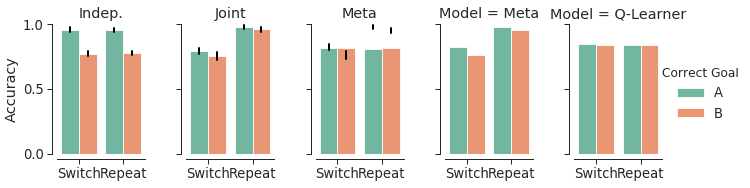

In [34]:
with sns.axes_style('ticks'):
    g = sns.catplot(
        hue='Correct Goal', y='Acc', data=stats_exp_2_goals[stats_exp_2_goals.Model != 'Flat'],
        kind='bar', col='Model',
        x='Task',  hue_order=['A', 'B'], ci=None,
        palette='Set2', height=3.0, aspect=0.63, estimator=np.median,
    )
    sns.despine(offset=5)

    g.set_xticklabels('Switch Repeat'.split())
    g.set_xlabels('')
    g.set_ylabels('Accuracy')
    g.axes[0][0].set_yticks(np.arange(0, 1.01, 0.5))
    g.axes[0][0].set_ylim(0.0, 1)

    g.axes[0][0].set_title('Indep.')
    g.axes[0][1].set_title('Joint')
    g.axes[0][2].set_title('Meta')
    
    # plot the error bars
    def _plot_hdi(model, ax):
        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'A') & 
            (stats_exp_2_goals['Correct Goal'] == 'A')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([-0.2, -0.2], [lb, ub], lw=2, color='k')
        
        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'A') & 
            (stats_exp_2_goals['Correct Goal'] == 'B')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([0.2, 0.2], [lb, ub], lw=2, color='k')

        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'B') & 
            (stats_exp_2_goals['Correct Goal'] == 'A')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([0.8, 0.8], [lb, ub], lw=2, color='k')
        v = stats_exp_2_goals.loc[
            (stats_exp_2_goals.Model == model) & 
            (stats_exp_2_goals.Task == 'B') & 
            (stats_exp_2_goals['Correct Goal'] == 'B')  ,'Acc'].values
        lb, ub = get_hdi(v)
        ax.plot([1.2, 1.2], [lb, ub], lw=2, color='k')
        
    _plot_hdi('Independent', g.axes[0][0])
    _plot_hdi('Joint', g.axes[0][1])
    _plot_hdi('Meta', g.axes[0][2])
#     plt.savefig('exp_2_goals_fig_models.png', dpi=300, bbox_inches='tight')

In [35]:
# get statistics on the simple effects
model = 'Independent'

def hdi_main_effect_task(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'B') ,'Acc'].values
    diff = v0 - v1
    diff.sort()    
    return np.mean(diff), get_hdi(diff)

def hdi_main_effect_goal(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'B') ,'Acc'].values
    diff = v0 - v1
    diff.sort()
    
    return np.mean(diff), get_hdi(diff)

print 'Independent (task): {}'.format(hdi_main_effect_task('Independent'))
print 'Independent (goal): {}'.format(hdi_main_effect_goal('Independent'))
print
print 'Joint (task): {}'.format(hdi_main_effect_task('Joint'))
print 'Joint (goal): {}'.format(hdi_main_effect_goal('Joint'))
print
print 'Meta (task): {}'.format(hdi_main_effect_task('Meta'))
print 'Meta (goal): {}'.format(hdi_main_effect_goal('Meta'))
print
print 'Flat (task): {}'.format(hdi_main_effect_task('Flat'))
print 'Flat (goal): {}'.format(hdi_main_effect_goal('Flat'))
print
print 'Q-Learner (task): {}'.format(hdi_main_effect_task('Q-Learner'))
print 'Q-Learner (goal): {}'.format(hdi_main_effect_goal('Q-Learner'))
print
print 'KalmanUCB (task): {}'.format(hdi_main_effect_task('KalmanUCB'))
print 'KalmanUCB (goal): {}'.format(hdi_main_effect_goal('KalmanUCB'))

Independent (task): (-0.0012453762755102054, (-0.02614795918367352, 0.026339285714285676))
Independent (goal): (0.18408274872448982, (0.15306122448979598, 0.21173469387755106))

Joint (task): (-0.1955479910714286, (-0.23207908163265312, -0.16065051020408172))
Joint (goal): (0.0246312181122449, (0.0, 0.061224489795918324))

Meta (task): (-0.17399784757653058, (-0.21677295918367356, -0.13217474489795922))
Meta (goal): (0.043738281250000004, (0.009375000000000022, 0.0892857142857143))

Flat (task): (-0.0011559311224489744, (-0.04285714285714293, 0.04400510204081631))
Flat (goal): (0.0006894132653061247, (-0.0357142857142857, 0.042187500000000044))

Q-Learner (task): (0.007597735969387755, (-0.038775510204081653, 0.06785714285714295))
Q-Learner (goal): (0.0013027742346938753, (-0.04336734693877553, 0.04531249999999998))

KalmanUCB (task): (0.0006278698979591802, (-0.03730867346938771, 0.03673469387755102))
KalmanUCB (goal): (-0.0005471938775510188, (-0.028061224489795977, 0.035714285714285

In [36]:
def main_effect_task_mean_sd(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'B') ,'Acc'].values
    diff = -v0 + v1
    diff.sort()    
    return np.mean(diff), np.std(diff)

def main_effect_goal_mean_sd(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'B') ,'Acc'].values
    diff = v0 - v1
    diff.sort()
    
    return np.mean(diff), np.std(diff)


In [37]:
model = 'Joint'
mu_goal, sd_goal = main_effect_goal_mean_sd(model)
mu_task, sd_task = main_effect_task_mean_sd(model) 
pd.DataFrame({
    "Comparison": ['Task', 'Goal'],
    'Mean': [mu_task, mu_goal],
})

,Comparison,Mean
0,Task,0.195548
1,Goal,0.024631


In [38]:

def plot_contrasts_exp_2_goals(model, model_name):
    with sns.plotting_context('paper', font_scale=1.75):
        with sns.axes_style('ticks'):
            fig, ax  = plt.subplots(figsize=(1.0, 2.5))
            mu_goal, sd_goal = main_effect_goal_mean_sd(model)
            mu_task, sd_task = main_effect_task_mean_sd(model) 
            sns.barplot(x='Comparison', y='Mean', 
                    data=pd.DataFrame({"Comparison": ['Task', 'Goal'],'Mean': [mu_task, mu_goal],}
                                     ), color='skyblue', ax=ax, ci=None,
                        order=['Task', 'Goal'])


            ax.set_ylabel(r'Difference Score', labelpad=-3)
            ax.set_xlabel('')
            ax.plot([-1, 2], [0, 0], 'k:')
            ax.set_xlim([-0.5, 1.5])
            ax.set_yticks(np.arange(-0.1, 0.35, 0.1))
            ax.set_ylim([-0.1, 0.35])
            sns.despine(offset=5)

            plt.xticks([0, 1], [r'Rep.', 'Goal' ], rotation='vertical')
    #         plt.xticks([0, 1], [r'R', 'G' ])

            def plot_stars(x0):
                ax.annotate("*", xy=(x0-0.175, 0.25), size=22)

            # plot the error bars
            _, (lb, ub) = hdi_main_effect_task(model)
            ax.plot([0, 0],[mu_task-sd_task, mu_task+sd_task], 'k', lw=2)

            if np.sign(lb) == np.sign(ub):
                plot_stars(0)

            _, (lb, ub) = hdi_main_effect_goal(model)
            ax.plot([1, 1],[mu_goal-sd_goal, mu_goal+sd_goal], 'k', lw=2)

            if np.sign(lb) == np.sign(ub):
                plot_stars(1)

            ax.set_title(model_name)
            return fig, ax

def plot_contrasts_exp_2_goals_to_save(model, model_name, height=0.75):
    with sns.plotting_context('paper', font_scale=0.5):
        with sns.axes_style('ticks'):
            fig, ax  = plt.subplots(figsize=(height/2.5, height))
            mu_goal, sd_goal = main_effect_goal_mean_sd(model)
            mu_task, sd_task = main_effect_task_mean_sd(model) 
            sns.barplot(x='Comparison', y='Mean', 
                    data=pd.DataFrame({"Comparison": ['Task', 'Goal'],'Mean': [mu_task, mu_goal],}
                                     ), color='skyblue', ax=ax, ci=None,
                        order=['Task', 'Goal'])


            ax.set_ylabel(r'Difference Score', labelpad=0)
#             ax.set_ylabel('')
            ax.set_xlabel('')
            ax.plot([-1, 2], [0, 0], 'k:')
            ax.set_xlim([-0.5, 1.5])
            ax.set_yticks(np.arange(-0.1, 0.35, 0.1))
            ax.set_ylim([-0.1, 0.35])
            sns.despine(offset=5)

            plt.xticks([0, 1], [r'Rep.', 'Goal' ], rotation='vertical')
    #         plt.xticks([0, 1], [r'R', 'G' ])

            def plot_stars(x0):
                ax.annotate("*", xy=(x0-0.175, 0.25), size=8)

            # plot the error bars
            _, (lb, ub) = hdi_main_effect_task(model)
            ax.plot([0, 0],[mu_task-sd_task, mu_task+sd_task], 'k', lw=1)

            if np.sign(lb) == np.sign(ub):
                plot_stars(0)

            _, (lb, ub) = hdi_main_effect_goal(model)
            ax.plot([1, 1],[mu_goal-sd_goal, mu_goal+sd_goal], 'k', lw=1)

            if np.sign(lb) == np.sign(ub):
                plot_stars(1)
                
            ax.spines['left'].set_lw(0.2)
            ax.spines['bottom'].set_lw(0.2)
            ax.tick_params(width=0.2)

            ax.set_title(model_name)
            return fig, ax



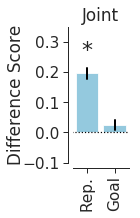

In [39]:
fig, _ = plot_contrasts_exp_2_goals('Joint', 'Joint')


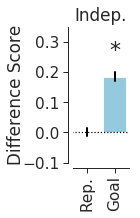

In [40]:
fig, _ = plot_contrasts_exp_2_goals('Independent', 'Indep.')

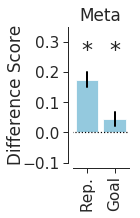

In [41]:
fig, _ = plot_contrasts_exp_2_goals('Meta', 'Meta')

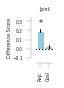

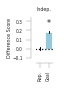

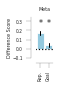

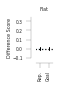

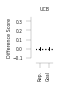

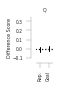

In [42]:
fig, ax = plot_contrasts_exp_2_goals_to_save('Joint', 'Joint')
fig.savefig('exp_2_goals_model_joint.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_2_goals_to_save('Independent', 'Indep.')
fig.savefig('exp_2_goals_model_indep.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_2_goals_to_save('Meta', 'Meta')
fig.savefig('exp_2_goals_model_meta.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_2_goals_to_save('Flat', 'Flat')
fig.savefig('exp_2_goals_model_flat.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_2_goals_to_save('KalmanUCB', 'UCB')
fig.savefig('exp_2_goals_model_kal.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_2_goals_to_save('Q-Learner', 'Q')
fig.savefig('exp_2_goals_model_q.png', dpi=300, bbox_inches='tight')

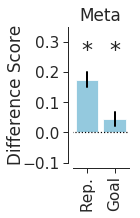

In [43]:
fig, _ = plot_contrasts_exp_2_goals('Meta', 'Meta')

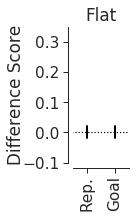

In [44]:
fig, _ = plot_contrasts_exp_2_goals('Flat', 'Flat')

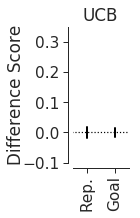

In [45]:
fig, _ = plot_contrasts_exp_2_goals('KalmanUCB', 'UCB')


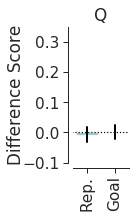

In [46]:
fig, _ = plot_contrasts_exp_2_goals('Q-Learner', 'Q')


In [47]:
fig.savefig('exp_2_goals_model_q.svg', dpi=300, bbox_inches='tight')

Independent: 1.0
Joint: 0.96
Meta: 0.995
Flat: 0.5075
Q: 0.51
UCB: 0.4425


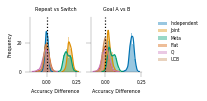

In [48]:
taskA = stats_exp_2_goals.Task == 'A'
goalA = stats_exp_2_goals['Correct Goal'] == 'A'
model = stats_exp_2_goals.Model
cc = sns.color_palette('colorblind')

with sns.plotting_context('paper', font_scale=0.5):
    _, axes = plt.subplots(1, 2, figsize=(2, 1.0), sharey=True)
    def plot_dist(m_name, label, ii):
            sns.distplot(stats_exp_2_goals.loc[(~taskA) & (model == m_name), 'Acc'].values - \
                         stats_exp_2_goals.loc[(taskA) & (model == m_name), 'Acc'].values, label=label, color=cc[ii],
                        ax=axes[0])

    plot_dist('Independent','Independent', 0)
    plot_dist('Joint','Joint', 1)
    plot_dist('Meta','Meta', 2)
    plot_dist('Flat', 'Flat', 3)
    plot_dist('Q-Learner', 'Q', 4)
    plot_dist('KalmanUCB', 'UCB', 5)

    def plot_dist(m_name, label, ii):
        sns.distplot(stats_exp_2_goals.loc[(goalA) & (model == m_name), 'Acc'].values - \
                     stats_exp_2_goals.loc[(~goalA) & (model == m_name), 'Acc'].values, label=label, color=cc[ii],
                    ax=axes[1])
        
        print "{}: {}".format(label, np.mean(stats_exp_2_goals.loc[(goalA) & (model == m_name), 'Acc'].values > \
                     stats_exp_2_goals.loc[(~goalA) & (model == m_name), 'Acc'].values))

    plot_dist('Independent','Independent', 0)
    plot_dist('Joint','Joint', 1)
    plot_dist('Meta','Meta', 2)
    plot_dist('Flat', 'Flat', 3)
    plot_dist('Q-Learner', 'Q', 4)
    plot_dist('KalmanUCB', 'UCB', 5)


    axes[0].set_ylabel('Frequency')
    axes[0].set_xlabel('Accuracy Difference')
    axes[0].set_title('Repeat vs Switch')

    axes[1].set_xlabel('Accuracy Difference')
    axes[1].set_title('Goal A vs B')
    sns.despine()
    
    for ax in axes:
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)

    lgd = axes[1].legend(loc='upper right', bbox_to_anchor=(2.2, 1.00), framealpha=0)

    for ii in [0, 1]: axes[ii].axvline(x=0, ls=':', color='k') 

    plt.savefig('exp_2_goals_effect_size_all.png', dpi=300,bbox_extra_artists=(lgd,),
                bbox_inches='tight')


In [49]:
model_acc_exp2 = stats_exp_2_goals.groupby(['Model']).mean().sort_values('Acc')

In [50]:
# for comparison, load the subject data
exp_2_goals_subj = pd.read_pickle('data/exp3_data.pkl')



excluded = generate_exclusion_list(exp_2_goals_subj, training_contexts=3, binom=False)
for e in excluded:
    exp_2_goals_subj = exp_2_goals_subj[exp_2_goals_subj.subj != e]
print len(list(set(exp_2_goals_subj.subj)))
exp_2_goals_subj['Accuracy'] = exp_2_goals_subj['Reward'] / 10.0
exp_2_goals_subj['Training'] = exp_2_goals_subj.loc[:, 'Context'] < 4

100%|██████████| 196/196 [00:42<00:00,  6.03it/s]


N clusters = 2, Covarainace = diag
129


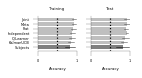

In [51]:
with sns.plotting_context('paper', font_scale=0.4):

    order = pd.DataFrame(exp_2_goals_acc).groupby(['Condition', 'Model']
                ).mean().loc['Training'].sort_values('Acc', ascending=False)

    g = sns.catplot(data=pd.DataFrame(exp_2_goals_acc),
                y='Model', x='Acc', ci='sd', col='Condition',
                col_order=['Training', 'Test'],
                kind='bar', orient='h', color=[0.75, 0.75, 0.75], height=1.0, 
                aspect=1., order=order.index, errwidth=0.5,
                   )

    plt.ylabel('')
    plt.xlim([0, 1])
    for ii in [0, 1]:
        g.axes[0][ii].set_xlabel('Accuracy')
        g.axes[0][ii].axvline(x=0.5, c='k', ls=':')
    df0 = sims_exp_4.groupby(['Model']).mean().sort_values('Acc')

    g.axes[0][0].set_ylabel('')

    g.axes[0][0].set_title('Training')
    g.axes[0][1].set_title('Test')

    for ax, _bool in zip(g.axes[0], [True, False]):
        mu = exp_2_goals_subj[
            (exp_2_goals_subj['In Goal']) & (_bool == exp_2_goals_subj['Training'])
        ].groupby('subj').mean().mean()['Accuracy']
        std = exp_2_goals_subj[
            exp_2_goals_subj['In Goal'] & (_bool == exp_2_goals_subj['Training'])
        ].groupby('subj').mean().std()['Accuracy'] 


        ax.barh([6.0], [mu], facecolor='k', alpha=0.5 )
        ax.plot([mu-std, mu+std], [6., 6.], c='k', lw=0.5)

    plt.ylabel('')
    plt.xlim([0, 1])
    plt.xlabel('Accuracy')
    
        
    for ax in g.axes[0]:
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)

    g.axes[0][0].set_yticks(range(0, 7))
    g.axes[0][0].set_yticklabels(order.index.to_list() + ['Subjects'])

    plt.savefig('exp_2_goals_acc.png', dpi=300)

In [52]:
# here we do significance testing to show that none of the batches
# of models is every below change at the group level

pd.DataFrame(exp_2_goals_acc).groupby(['Model','Condition','Batch']
                                     ).mean().groupby(['Model','Condition']).min()

Acc    Iteration
Model       Condition                       
Flat        Test       0.887597  2609.217054
            Training   0.889535  2609.217054
Independent Test       0.911337  2609.217054
            Training   0.864341  2609.217054
Joint       Test       0.912791  2609.217054
            Training   0.910853  2609.217054
KalmanUCB   Test       0.828004  2609.217054
            Training   0.826550  2609.217054
Meta        Test       0.918120  2609.217054
            Training   0.902132  2609.217054
Q-Learner   Test       0.861434  2609.217054
            Training   0.859012  2609.217054

In [53]:
# here we do signficiance testing to show whether there is a benefit to generalization

comp_df = pd.DataFrame(exp_2_goals_acc)
# batch_v = comp_df.Batch
training_v = comp_df.Condition == 'Training'
acc_meas = []
for ii in set(comp_df.Batch):
    # get the accuracy of the Joint and flat models in each condition
    b = comp_df.Batch == ii
    acc_meas.append({
        'Overall': comp_df.loc[b & (comp_df.Model == 'Joint'), 'Acc'].mean() - \
                   comp_df.loc[b & (comp_df.Model == 'Flat'), 'Acc'].mean(),
        'Training':comp_df.loc[b & (comp_df.Model == 'Joint') & training_v, 'Acc'].mean() - \
                   comp_df.loc[b & (comp_df.Model == 'Flat') & training_v, 'Acc'].mean(),
        'Test':comp_df.loc[b & (comp_df.Model == 'Joint') & (training_v==False), 'Acc'].mean() - \
               comp_df.loc[b & (comp_df.Model == 'Flat') & (training_v==False), 'Acc'].mean(),
        'batch': ii
        
    })
    
acc_meas = pd.DataFrame(acc_meas)


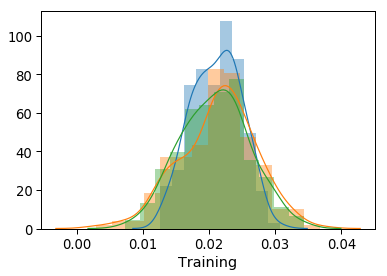

In [54]:
sns.distplot(acc_meas.Overall, label='Overall')
sns.distplot(acc_meas.Test, label='Test')
sns.distplot(acc_meas.Training, label='Training')

In [55]:
print np.mean(acc_meas.Training), np.mean(acc_meas.Training < 0)
print np.mean(acc_meas.Test), np.mean(acc_meas.Test < 0)

0.02090116279069762 0.0
0.021366279069767388 0.0


In [56]:
# here we do signficiance testing to show whether there is a benefit to generalization

comp_df = pd.DataFrame(exp_2_goals_acc)
# batch_v = comp_df.Batch
training_v = comp_df.Condition == 'Training'
acc_meas = []
for ii in set(comp_df.Batch):
    # get the accuracy of the Joint and flat models in each condition
    b = comp_df.Batch == ii
    acc_meas.append({
        'Overall': comp_df.loc[b & (comp_df.Model == 'Joint'), 'Acc'].mean() - \
                   comp_df.loc[b & (comp_df.Model == 'Independent'), 'Acc'].mean(),
        'Training':comp_df.loc[b & (comp_df.Model == 'Joint') & training_v, 'Acc'].mean() - \
                   comp_df.loc[b & (comp_df.Model == 'Independent') & training_v, 'Acc'].mean(),
        'Test':comp_df.loc[b & (comp_df.Model == 'Joint') & (training_v==False), 'Acc'].mean() - \
               comp_df.loc[b & (comp_df.Model == 'Independent') & (training_v==False), 'Acc'].mean(),
        'batch': ii
        
    })
    
acc_meas = pd.DataFrame(acc_meas)

print np.mean(acc_meas.Training), np.mean(acc_meas.Training < 0)
print np.mean(acc_meas.Test), np.mean(acc_meas.Test < 0)

0.044297480620155004 0.0
0.00338178294573644 0.205


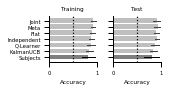

In [57]:
with sns.plotting_context('paper',font_scale=0.6):
    order = pd.DataFrame(exp_2_goals_acc).groupby(['Condition', 'Model']
            ).mean().loc['Training'].sort_values('Acc', ascending=False)

    g = sns.catplot(data=pd.DataFrame(exp_2_goals_acc),
                y='Model', x='Acc', ci='sd', col='Condition',
                col_order=['Training', 'Test'],
                kind='bar', orient='h', color=[0.75, 0.75, 0.75], height=1.25, 
                aspect=1., order=order.index, errwidth=1.0,
                   )

    plt.ylabel('')
    plt.xlim([0, 1])
    for ii in [0, 1]:
        g.axes[0][ii].set_xlabel('Accuracy')
        g.axes[0][ii].axvline(x=0.5, c='k', ls=':')
    df0 = sims_exp_4.groupby(['Model']).mean().sort_values('Acc')

    g.axes[0][0].set_ylabel('')

    g.axes[0][0].set_title('Training')
    g.axes[0][1].set_title('Test')

    for ax, _bool in zip(g.axes[0], [True, False]):
        mu = exp_2_goals_subj[
            (exp_2_goals_subj['In Goal']) & (_bool == exp_2_goals_subj['Training'])
        ].groupby('subj').mean().mean()['Accuracy']
        std = exp_2_goals_subj[
            exp_2_goals_subj['In Goal'] & (_bool == exp_2_goals_subj['Training'])
        ].groupby('subj').mean().std()['Accuracy'] 


        ax.barh([6.0], [mu], facecolor='k', alpha=0.5 )
        ax.plot([mu-std, mu+std], [6., 6.], c='k', lw=1)

    plt.ylabel('')
    plt.xlim([0, 1])
    plt.xlabel('Accuracy')

    g.axes[0][0].set_yticks(range(0, 7))
    g.axes[0][0].set_yticklabels(order.index.to_list() + ['Subjects'])

    plt.savefig('temp.svg', dpi=300)

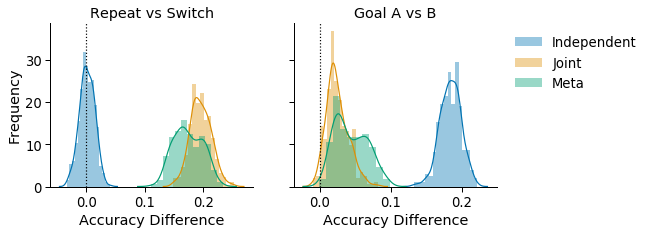

In [58]:
taskA = stats_exp_2_goals.Task == 'A'
goalA = stats_exp_2_goals['Correct Goal'] == 'A'
model = stats_exp_2_goals.Model
cc = sns.color_palette('colorblind')

_, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

def plot_dist(m_name, ii):
    sns.distplot(stats_exp_2_goals.loc[(~taskA) & (model == m_name), 'Acc'].values - \
                 stats_exp_2_goals.loc[(taskA) & (model == m_name), 'Acc'].values, label=m_name, color=cc[ii],
                ax=axes[0])

plot_dist('Independent', 0)
plot_dist('Joint', 1)
plot_dist('Meta', 2)

def plot_dist(m_name, ii):
    sns.distplot(stats_exp_2_goals.loc[(goalA) & (model == m_name), 'Acc'].values - \
                 stats_exp_2_goals.loc[(~goalA) & (model == m_name), 'Acc'].values, label=m_name, color=cc[ii],
                ax=axes[1])

plot_dist('Independent', 0)
plot_dist('Joint', 1)
plot_dist('Meta', 2)

axes[1].legend(loc='upper right', bbox_to_anchor=(2.0, 1.0))
axes[0].set_ylabel('Frequency')
axes[0].set_xlabel('Accuracy Difference')
axes[0].set_title('Repeat vs Switch')

axes[1].set_xlabel('Accuracy Difference')
axes[1].set_title('Goal A vs B')
sns.despine()


lgd = axes[1].legend(loc='upper right', bbox_to_anchor=(1.75, 1.0), framealpha=0)

for ii in [0, 1]: axes[ii].axvline(x=0, ls=':', color='k') 

plt.savefig('exp_2_goals_effect_size_genonly.png', dpi=300,bbox_extra_artists=(lgd,),
            bbox_inches='tight')



# Experiment 2: Independent Structure

In [59]:
def get_hdi_exp4goals(df, model, comparison, hdi=0.95):
    v = df.loc[(df.Model==model) & (df.Comparison == comparison), 'Mean'].values
    return get_hdi(v, hdi)

def get_mean_exp_4_goals(df, model, comparison, hdi=0.95):
    tail = (1. - hdi) / 2
    v = df.loc[(df.Model==model) & (df.Comparison == comparison), 'Mean'].values
    return v.mean()

def score_acc_4_goals(sampled_batch, batch=0):
    accuracy = list()
    
    df0 = sampled_batch[sampled_batch['In Goal']].copy()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
            accuracy.append({
                'Condition': 'Training',
                'Acc': subj_df.loc[subj_df.Context < 7, 'Acc'].mean(),
                'Iteration': it,
                'Model': m,
                'Batch': ii,
            })
            accuracy.append({
                'Condition': 'Test',
                'Acc': subj_df.loc[subj_df.Context >= 7, 'Acc'].mean(),
                'Iteration': it,
                'Model': m,
                'Batch': ii,
            })
    return accuracy
            


def score_experiment_4_goals(sampled_batch):
  
    df0 = sampled_batch[sampled_batch['In Goal'] 
                  & (sampled_batch.Context >= 7) 
                 ].copy()
    
    score = list()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]

            a = (subj_df.Context == 7)
            b = (subj_df.Context == 8)
            diff_1 = subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 7) | (subj_df.Context == 8)
            b = (subj_df.Context == 9) | (subj_df.Context == 10)
            diff_2 =subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 9)
            b = (subj_df.Context == 10)
            diff_3 = \
                subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']


            n = len(diff_1)
            for t in range(len(diff_1)):
                score.append({
                            'Trials in Context': t,
                            'Comparison': 'T1 vs T2',
                            'Difference Score': diff_1.values[t],
                            'Iteration': it,
                            'Model': m,
                    })
                
            for t in range(len(diff_2)):
                score.append({
                            'Trials in Context': t,
                            'Comparison': 'T1+2 vs T3+4',
                            'Difference Score': diff_2.values[t],
                            'Iteration': it,
                            'Model': m,
                    })
                
            for t in range(len(diff_3)):
                score.append({
                            'Trials in Context': t,
                            'Comparison': 'T3 vs T4',
                            'Difference Score': diff_3.values[t],
                            'Iteration': it,
                            'Model': m,
                    })
                

    return pd.DataFrame(score) 


In [60]:
stats_exp_4_goals = []

n_batches = 200
# n_batches = 5
hdi_interval = 0.95

goal_counts_exp_4_goals = []
exp_4_goals_acc = []

for ii in tnrange(n_batches):
    batched_data = draw_batch(sims_exp_4, batch_size=114)
    
    # count the goals tried in the first trial of each test context
    gcd = batched_data[batched_data['In Goal'] & (batched_data.Context > 6) & 
                   (batched_data['Times Seen Context'] == 1) 
                      ].copy()
    gcd['Map'] = ['1'] * len(gcd)
    gcd.loc[(gcd.Context == 7) | (gcd.Context == 8), 'Map'] = 1
    gcd.loc[(gcd.Context == 9) | (gcd.Context == 10), 'Map'] = 2
    gcd['Sample'] = ii

    # Because "In Goal" is a boolean that is always true here, we count that
    goal_counts_exp_4_goals.append(
        gcd.groupby(['Model', 'Map', 'Chosen Goal']).count()['In Goal'].reset_index()
    )
    
    
    # get the difference scores
    scored = score_experiment_4_goals(batched_data)
    stats_exp_4_goals += get_diff_stats(scored, idx=ii)
    
    # get the overall accuracy
    exp_4_goals_acc += score_acc_4_goals(batched_data, batch=ii)
    
stats_exp_4_goals = pd.DataFrame(stats_exp_4_goals)
goal_counts_exp_4_goals = pd.concat(goal_counts_exp_4_goals)

In [61]:
# load subject data for the accuracy comparison

exp_4_goals_subj = pd.read_pickle('data/exp2_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(
    exp_4_goals_subj, training_contexts=7, goal_chance=1/4.)
for e in excluded:
    exp_4_goals_subj = exp_4_goals_subj[exp_4_goals_subj.subj != e]
uids = list(set(exp_4_goals_subj.subj))
exp_4_goals_subj['Accuracy'] = exp_4_goals_subj['Reward'] / 10.0
exp_4_goals_subj['Training'] = exp_4_goals_subj.loc[:, 'Context'] < 8


100%|██████████| 148/148 [01:51<00:00,  1.26it/s]


N clusters = 2, Covarainace = diag


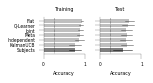

In [62]:
with sns.plotting_context('paper', font_scale=0.5):


    order = pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model']
                ).mean().loc['Training'].sort_values('Acc', ascending=False)

    g = sns.catplot(data=pd.DataFrame(exp_4_goals_acc),
                y='Model', x='Acc', ci='sd', col='Condition',
                col_order=['Training', 'Test'],
                kind='bar', orient='h', color=[0.75, 0.75, 0.75], height=1.1, 
                aspect=1., order=order.index, errwidth=0.5,
                   )

    plt.ylabel('')
    plt.xlim([0, 1])
    for ii in [0, 1]:
        g.axes[0][ii].set_xlabel('Accuracy')
        g.axes[0][ii].axvline(x=0.25, c='k', ls=':', lw=0.5)
    df0 = sims_exp_4.groupby(['Model']).mean().sort_values('Acc')

    g.axes[0][0].set_ylabel('')

    g.axes[0][0].set_title('Training')
    g.axes[0][1].set_title('Test')

    for ax, _bool in zip(g.axes[0], [True, False]):
        mu = exp_4_goals_subj[
            (exp_4_goals_subj['In Goal']) & (_bool == exp_4_goals_subj['Training'])
        ].groupby('subj').mean().mean()['Accuracy']
        std = exp_4_goals_subj[
            exp_4_goals_subj['In Goal'] & (_bool == exp_4_goals_subj['Training'])
        ].groupby('subj').mean().std()['Accuracy'] 


        ax.barh([6.0], [mu], facecolor='k', alpha=0.5 )
        ax.plot([mu-std, mu+std], [6., 6.], c='k', lw=0.5)

    plt.ylabel('')
    plt.xlim([0, 1])
    plt.xlabel('Accuracy')
            
    for ax in g.axes[0]:
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)

    g.axes[0][0].set_yticks(range(0, 7))
    g.axes[0][0].set_yticklabels(order.index.to_list() + ['Subjects'])

    plt.savefig('exp_4_goals_acc.png', dpi=300)

In [63]:
pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model', 'Batch'
                                      ]).mean().groupby(['Condition', 'Model']).mean()

Acc    Iteration
Condition Model                             
Test      Flat         0.711974  1251.014518
          Independent  0.635459  1251.014518
          Joint        0.640049  1251.014518
          KalmanUCB    0.649819  1251.014518
          Meta         0.642346  1251.014518
          Q-Learner    0.677482  1251.014518
Training  Flat         0.923036  1251.014518
          Independent  0.856609  1251.014518
          Joint        0.887887  1251.014518
          KalmanUCB    0.757388  1251.014518
          Meta         0.878155  1251.014518
          Q-Learner    0.910382  1251.014518

In [64]:
diff_test = pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model', 'Batch'
                                      ]).mean().loc['Test'].loc['Flat', 'Acc'] - \
    pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model', 'Batch'
                                      ]).mean().loc['Test'].loc['Meta', 'Acc']
print np.mean(diff_test), ttest_1samp(diff_test, 0)

0.06962719298245616 Ttest_1sampResult(statistic=65.74624929899616, pvalue=6.255308164400026e-137)


In [65]:
diff_test = pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model', 'Batch'
                                      ]).mean().loc['Training'].loc['Flat', 'Acc'] - \
    pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model', 'Batch'
                                      ]).mean().loc['Training'].loc['Joint', 'Acc']
print np.mean(diff_test), ttest_1samp(diff_test, 0)

0.0351488486842106 Ttest_1sampResult(statistic=86.44061686762126, pvalue=8.929725007481405e-160)


In [66]:
stats_exp_4_goals['Power'] = (stats_exp_4_goals['p-value'].copy() < 0.05)
stats_exp_4_goals.groupby(['Model', 'Comparison']).mean()

Mean  Sample   d-prime     df       p-value  \
Model       Comparison                                                      
Flat        T1 vs T2     -0.007478    99.5 -0.022950  113.0  4.663787e-01   
            T1+2 vs T3+4 -0.002171    99.5 -0.009378  113.0  5.209032e-01   
            T3 vs T4      0.006586    99.5  0.019750  113.0  5.067846e-01   
Independent T1 vs T2      0.168509    99.5  0.505447  113.0  1.180066e-04   
            T1+2 vs T3+4  0.254507    99.5  1.012795  113.0  1.918648e-12   
            T3 vs T4      0.000197    99.5  0.000041  113.0  5.023775e-01   
Joint       T1 vs T2     -0.003041    99.5 -0.009131  113.0  4.939505e-01   
            T1+2 vs T3+4  0.161714    99.5  0.629202  113.0  4.631667e-06   
            T3 vs T4     -0.124963    99.5 -0.362961  113.0  4.949671e-03   
KalmanUCB   T1 vs T2      0.003136    99.5  0.014829  113.0  4.822808e-01   
            T1+2 vs T3+4 -0.000625    99.5 -0.004482  113.0  5.109469e-01   
            T3 vs T4     -0.003392    99.5 -0.015356  113.0  4.974277e-01   
Meta        T1 vs T2      0.071959    99.5  0.231200  113.0  6.962698e-02   
            T1+2 vs T3+4  0.229971    99.5  0.907180  113.0  7.409221e-12   
            T3 vs T4     -0.073392    99.5 -0.230221  113.0  6.653035e-02   
Q-Learner   T1 vs T2      0.001871    99.5  0.005772  113.0  5.490552e-01   
            T1+2 vs T3+4 -0.006133    99.5 -0.027155  113.0  4.956251e-01   
            T3 vs T4     -0.003246    99.5 -0.010198  113.0  5.296172e-01   

                          t-statistic  Power  
Model       Comparison                        
Flat        T1 vs T2        -0.243967  0.065  
            T1+2 vs T3+4    -0.099687  0.035  
            T3 vs T4         0.209943  0.030  
Independent T1 vs T2         5.372974  1.000  
            T1+2 vs T3+4    10.766158  1.000  
            T3 vs T4         0.000439  0.025  
Joint       T1 vs T2        -0.097062  0.040  
            T1+2 vs T3+4     6.688508  1.000  
            T3 vs T4        -3.858329  0.990  
KalmanUCB   T1 vs T2         0.157629  0.075  
            T1+2 vs T3+4    -0.047640  0.045  
            T3 vs T4        -0.163241  0.065  
Meta        T1 vs T2         2.457686  0.700  
            T1+2 vs T3+4     9.643453  1.000  
            T3 vs T4        -2.447283  0.690  
Q-Learner   T1 vs T2         0.061358  0.045  
            T1+2 vs T3+4    -0.288665  0.030  
            T3 vs T4        -0.108406  0.045

In [67]:
hdi = []
std_error = stats_exp_4_goals.groupby(['Model', 'Comparison']).std()['Mean']

for comparison in set(stats_exp_4_goals.Comparison):
    for model in set(stats_exp_4_goals.Model):
        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, comparison, hdi=hdi_interval)
        hdi.append({
            'Comparison': comparison,
            'Model': model,
            'Mean': get_mean_exp_4_goals(stats_exp_4_goals, model, comparison),
            'Lower Bound': lb,
            'Upper Bound': ub,
            'Std Error': std_error.loc[model][comparison]
        })
hdi_data_exp_4_goals = pd.DataFrame(hdi)
# hdi_data_exp_4_goals

In [68]:
hdi_data_exp_4_goals.loc[(hdi_data_exp_4_goals.Model == 'Q-Learner') & 
                         (hdi_data_exp_4_goals.Comparison == 'T1 vs T2'), 'Mean'].values[-1]

0.001871345029239766

In [69]:
hdi_data_exp_4_goals.sort_values(['Comparison', 'Model'])[['Comparison', 'Model','Mean', 'Lower Bound',
                                                         'Upper Bound', 'Std Error']]

,Comparison,Model,Mean,Lower Bound,Upper Bound,Std Error
1,T1 vs T2,Flat,-0.007478,-0.067251,0.057018,0.034359
2,T1 vs T2,Independent,0.168509,0.108187,0.238304,0.029929
3,T1 vs T2,Joint,-0.003041,-0.048246,0.057018,0.028315
5,T1 vs T2,KalmanUCB,0.003136,-0.043860,0.046784,0.022099
4,T1 vs T2,Meta,0.071959,0.019006,0.118421,0.025698
0,T1 vs T2,Q-Learner,0.001871,-0.049708,0.070175,0.029830
13,T1+2 vs T3+4,Flat,-0.002171,-0.039474,0.038743,0.020252
14,T1+2 vs T3+4,Independent,0.254507,0.203947,0.304094,0.024275
15,T1+2 vs T3+4,Joint,0.161714,0.114035,0.210526,0.024288
17,T1+2 vs T3+4,KalmanUCB,-0.000625,-0.029240,0.029971,0.014645


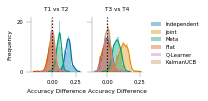

In [70]:
comp1 = stats_exp_4_goals.Comparison =='T1 vs T2'
comp2 = stats_exp_4_goals.Comparison =='T3 vs T4'
model = stats_exp_4_goals.Model
cc = sns.color_palette('colorblind')

with sns.plotting_context('paper', font_scale=0.6):
    _, axes = plt.subplots(1, 2, figsize=(2, 1.), sharey=True)
    def plot_dist(m_name, ii):
            sns.distplot(stats_exp_4_goals.loc[(comp1) & (model == m_name), 'Mean'].values, label=m_name, color=cc[ii],
                        ax=axes[0])

    plot_dist('Independent', 0)
    plot_dist('Joint', 1)
    plot_dist('Meta', 2)
    plot_dist('Flat', 3)
    plot_dist('Q-Learner', 4)
    plot_dist('KalmanUCB', 5)

    def plot_dist(m_name, ii):
        sns.distplot(-1 * stats_exp_4_goals.loc[(comp2) & (model == m_name), 'Mean'].values, label=m_name, color=cc[ii],
                    ax=axes[1])

    plot_dist('Independent', 0)
    plot_dist('Joint', 1)
    plot_dist('Meta', 2)
    plot_dist('Flat', 3)
    plot_dist('Q-Learner', 4)
    plot_dist('KalmanUCB', 5)


    axes[0].set_ylabel('Frequency')
    axes[0].set_xlabel('Accuracy Difference')
    axes[0].set_title('T1 vs T2')

    axes[1].set_xlabel('Accuracy Difference')
    axes[1].set_title('T3 vs T4')
    sns.despine()
    
    for ax in axes:
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)

    lgd = axes[1].legend(loc='upper right', bbox_to_anchor=(2.2, 1.00), framealpha=0)

    for ii in [0, 1]: axes[ii].axvline(x=0, ls=':', color='k') 

    plt.savefig('exp_4_goals_effect_size_all.png', dpi=300,bbox_extra_artists=(lgd,),
                bbox_inches='tight')



In [71]:



def main_effect_mean_sd(model, comp):
    v0 = stats_exp_4_goals.loc[
                (stats_exp_4_goals.Model == model) & 
                (stats_exp_4_goals.Comparison == comp) ,'Mean'].values
    return np.mean(v0), np.std(v0)

sns.set_context('paper', font_scale=1.75)
def plot_contrasts_exp_4_goals(model, model_name, hdi=0.95):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(1.0, 2.5))  
        sns.barplot(x='Comparison', y='Mean', 
                data=hdi_data_exp_4_goals[
                    (hdi_data_exp_4_goals.Model == model) & 
                    ((hdi_data_exp_4_goals.Comparison =='T1 vs T2' ) |
                    (hdi_data_exp_4_goals.Comparison == 'T3 vs T4'))], color='skyblue', ax=ax, ci="sd",
                    order=['T1 vs T2',  'T3 vs T4'])
        
#         sns.barplot(x='Comparison', y='Mean', 
#                 data=hdi_data_exp_4_goals[hdi_data_exp_4_goals.Model == model], color='skyblue', ax=ax, 
#                     order=['T1 vs T2', 'T1+2 vs T3+4', 'T3 vs T4'])
        ax.set_ylabel(r'Difference Score', labelpad=-3)
        ax.set_xlabel('')
        ax.plot([-1, 2], [0, 0], 'k:')
        ax.set_xlim([-0.5, 1.5])
        ax.set_yticks(np.arange(-0.2, 0.35, 0.1))
        ax.set_ylim([-0.2, 0.35])
        sns.despine(offset=5)
        
        plt.xticks([0, 1], [r'1 > 2',  r'3 > 4' ], rotation='vertical')
        
        def plot_stars(x0):
            ax.annotate("*", xy=(x0-0.29, 0.28), size=22)
        
        # plot the error bars
        # plot the error bars
        mu, sd = main_effect_mean_sd(model, 'T1 vs T2')
        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T1 vs T2', hdi)
        ax.plot([0, 0],[mu-sd, mu+sd], 'k', lw=2)
        if np.sign(lb) == np.sign(ub):
            plot_stars(0)


        mu, sd = main_effect_mean_sd(model, 'T3 vs T4')
        lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T3 vs T4', hdi)
        ax.plot([1, 1],[mu-sd, mu+sd], 'k', lw=2)



        if np.sign(lb) == np.sign(ub):
            plot_stars(1)
        
        ax.set_title(model_name)
        return fig, ax
    



def plot_contrasts_exp_4_goals_to_save(model, model_name, height=0.75, hdi=0.95):
    with sns.plotting_context('paper', font_scale=0.5):
        with sns.axes_style('ticks'):
            fig, ax  = plt.subplots(figsize=(height/2.5, height))
            
            sns.barplot(x='Comparison', y='Mean', 
                    data=hdi_data_exp_4_goals[
                        (hdi_data_exp_4_goals.Model == model) & 
                        ((hdi_data_exp_4_goals.Comparison =='T1 vs T2' ) |
                        (hdi_data_exp_4_goals.Comparison == 'T3 vs T4'))], color='skyblue', ax=ax, ci="sd",
                        order=['T1 vs T2',  'T3 vs T4'])
            
            ax.set_ylabel(r'Difference Score', labelpad=0)
            ax.set_xlabel('')
            ax.plot([-1, 2], [0, 0], 'k:', lw=0.5)
            ax.set_xlim([-0.5, 1.5])
            ax.set_yticks(np.arange(-0.2, 0.35, 0.1))
            ax.set_ylim([-0.2, 0.35])
            sns.despine(offset=5)

            plt.xticks([0, 1], [r'1 > 2',  r'3 > 4' ], rotation='vertical')

            def plot_stars(x0):
                ax.annotate("*", xy=(x0-0.175, 0.25), size=8)

            # plot the error bars
            mu, sd = main_effect_mean_sd(model, 'T1 vs T2')
            lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T1 vs T2', hdi)
            ax.plot([0, 0],[mu-sd, mu+sd], 'k', lw=0.5)
            if np.sign(lb) == np.sign(ub):
                plot_stars(0)


            mu, sd = main_effect_mean_sd(model, 'T3 vs T4')
            lb, ub = get_hdi_exp4goals(stats_exp_4_goals, model, 'T3 vs T4', hdi)
            ax.plot([1, 1],[mu-sd, mu+sd], 'k', lw=0.5)

            if np.sign(lb) == np.sign(ub):
                plot_stars(1)

            ax.set_title(model_name)
            ax.spines['left'].set_lw(0.2)
            ax.spines['bottom'].set_lw(0.2)
            ax.tick_params(width=0.2)


            
            return fig, ax
    
    



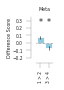

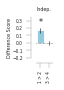

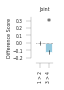

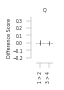

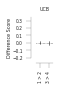

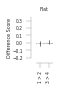

In [72]:
fig, _ = plot_contrasts_exp_4_goals_to_save('Meta', 'Meta')
fig.savefig('exp_4_goals_model_meta.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_4_goals_to_save('Independent', 'Indep.')
fig.savefig('exp_4_goals_model_indep.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_4_goals_to_save('Joint', 'Joint')
fig.savefig('exp_4_goals_model_joint.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_4_goals_to_save('Q-Learner', 'Q')
fig.savefig('exp_4_goals_model_q.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_4_goals_to_save('KalmanUCB', 'UCB')
fig.savefig('exp_4_goals_model_kal.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_4_goals_to_save('Flat', 'Flat')
fig.savefig('exp_4_goals_model_flat.png', dpi=300, bbox_inches='tight')



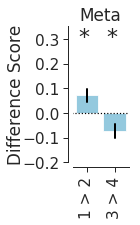

In [73]:
fig, _ = plot_contrasts_exp_4_goals('Meta', 'Meta', hdi=hdi_interval)


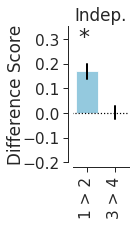

In [74]:
fig, _ = plot_contrasts_exp_4_goals('Independent', 'Indep.', hdi=0.9)


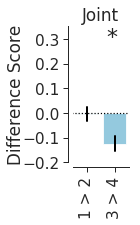

In [75]:
fig, _ = plot_contrasts_exp_4_goals('Joint', 'Joint', hdi=hdi_interval)
fig.savefig('exp_4_goals_model_joint.png', dpi=300, bbox_inches='tight')

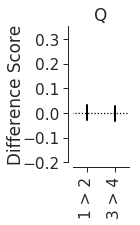

In [76]:
fig, _ = plot_contrasts_exp_4_goals('Q-Learner', 'Q', hdi=hdi_interval)
fig.savefig('exp_4_goals_model_q.png', dpi=300, bbox_inches='tight')


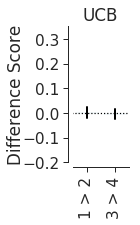

In [77]:
fig, _ = plot_contrasts_exp_4_goals('KalmanUCB', 'UCB', hdi=hdi_interval)
fig.savefig('exp_4_goals_model_kal.png', dpi=300, bbox_inches='tight')


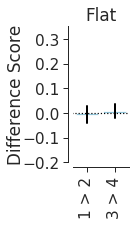

In [78]:
fig, _ = plot_contrasts_exp_4_goals('Flat', 'Flat', hdi=hdi_interval)
fig.savefig('exp_4_goals_model_flat.png', dpi=300, bbox_inches='tight')



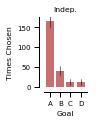

In [79]:
def plot_counts(model, title, map_, hdi=0.95):
    with sns.plotting_context('paper', font_scale=0.8):
        
        height = 1.75

        fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0/2.5 * height, height))

        if map_ == 2:
            c = sns.color_palette('muted')[3]
        else:
            c = sns.color_palette('muted')[0]

        df0 = goal_counts_exp_4_goals[
            (goal_counts_exp_4_goals.Model == model) & (goal_counts_exp_4_goals.Map == map_)
        ]

        sns.barplot(x="Chosen Goal", y="In Goal", order='A B C D'.split(),
                    data=df0, ax=ax, color=c, ci=None)

        # get the HDI for each of the counts
        for x, g in enumerate('A B C D'.split()):
            mu = np.mean(get_hdi(df0.loc[df0['Chosen Goal'] == g, 'In Goal'].values))
            sd = np.std(get_hdi(df0.loc[df0['Chosen Goal'] == g, 'In Goal'].values))
            ax.plot([x, x],[mu-sd, mu+sd], 'k', lw=0.5)


        ax.set_ylabel('Times Chosen')
        ax.set_xlabel('Goal')
        ax.set_title(title)
        ax.set_yticks([0,50,100, 150])
        ax.set_ylim([0, 175])

        sns.despine(offset=5)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
plot_counts('Independent', 'Indep.', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_indep_2.png', dpi=300, bbox_inches='tight')

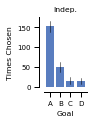

In [80]:
plot_counts('Independent', 'Indep.', map_=1, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_indep_3.png', dpi=300, bbox_inches='tight')

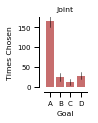

In [81]:
plot_counts('Joint', 'Joint', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_joint_2.png', dpi=300, bbox_inches='tight')

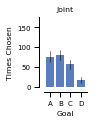

In [82]:
plot_counts('Joint', 'Joint', map_=1, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_joint_3.png', dpi=300, bbox_inches='tight')

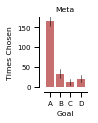

In [83]:
plot_counts('Meta', 'Meta', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_meta_2.png', dpi=300, bbox_inches='tight')

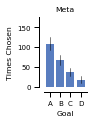

In [84]:
plot_counts('Meta', 'Meta', map_=1, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_meta_3.png', dpi=300, bbox_inches='tight')

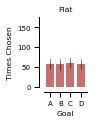

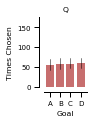

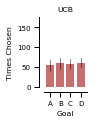

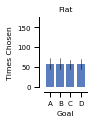

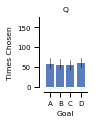

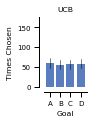

In [85]:
plot_counts('Flat', 'Flat', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_flat_2.png', dpi=300, bbox_inches='tight')
plot_counts('Q-Learner', 'Q', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_q_2.png', dpi=300, bbox_inches='tight')
plot_counts('KalmanUCB', 'UCB', map_=2, hdi=hdi_interval)
plt.savefig('exp_4_goals_model_ucb_2.png', dpi=300, bbox_inches='tight')


plot_counts('Flat', 'Flat', map_=1, hdi=hdi_interval)
plot_counts('Q-Learner', 'Q', map_=1, hdi=hdi_interval)
plot_counts('KalmanUCB', 'UCB', map_=1, hdi=hdi_interval)



In [86]:
# def get_goal_diff_score(model, _map):
#     diff_score = []

#     for ii in range(n_batches):
#         vec =         (goal_counts_exp_4_goals.Model == model) &\
#             (goal_counts_exp_4_goals.Map == _map) & \
#             (goal_counts_exp_4_goals.Batch == ii)
#         A = goal_counts_exp_4_goals.loc[vec & (goal_counts_exp_4_goals['Chosen Goal'] == 'A'), 'In Goal'].values[0]
#         B = goal_counts_exp_4_goals.loc[vec & (goal_counts_exp_4_goals['Chosen Goal'] == 'B'), 'In Goal'].values[0]
#         C = goal_counts_exp_4_goals.loc[vec & (goal_counts_exp_4_goals['Chosen Goal'] == 'C'), 'In Goal'].values[0]
#         diff_score.append(A - 0.5 * (B + C))
#     return np.array(diff_score)

# with sns.plotting_context('talk'):
#     sns.distplot(get_goal_diff_score('Joint', 1), label='Joint')
#     sns.distplot(get_goal_diff_score('Independent', 1), label='Indep.')
#     sns.distplot(get_goal_diff_score('Meta', 1), label='Meta')
#     plt.legend()
#     plt.axvline(x=0, ls=':')
#     sns.despine()
    
#     plt.figure()
#     sns.distplot(get_goal_diff_score('Joint', 2), label='Joint')
#     sns.distplot(get_goal_diff_score('Independent', 2), label='Indep.')
#     sns.distplot(get_goal_diff_score('Meta', 2), label='Meta')
#     plt.legend()
#     plt.axvline(x=0, ls=':')
#     sns.despine()

In [87]:
# # there are 6 models, 4 Goals and 2 Maps, or 48 rows per batch
# batch_id = [[ii] * 48 for ii in range (n_batches)]
# goal_counts_exp_4_goals['Batch'] = np.concatenate(batch_id)

# def plot_counts_effectsize(model, title, hdi=0.95):
#     with sns.plotting_context('paper', font_scale=0.8):
        
# #         height = 1.75

#         fig, ax = plt.subplots(1, 1, sharey=True)

#         if map_ == 2:
#             c = sns.color_palette('muted')[3]
#         else:
#             c = sns.color_palette('muted')[0]

#         df0 = goal_counts_exp_4_goals[
#             (goal_counts_exp_4_goals.Model == model) & (goal_counts_exp_4_goals.Map == map_)
#         ]

#         sns.barplot(x="Chosen Goal", y="In Goal", order='A B C D'.split(),
#                     data=df0, ax=ax, color=c, ci=None)

#         # get the HDI for each of the counts
#         for x, g in enumerate('A B C D'.split()):
#             mu = np.mean(get_hdi(df0.loc[df0['Chosen Goal'] == g, 'In Goal'].values))
#             sd = np.std(get_hdi(df0.loc[df0['Chosen Goal'] == g, 'In Goal'].values))
#             ax.plot([x, x],[mu-sd, mu+sd], 'k', lw=0.5)


#         ax.set_ylabel('Times Chosen')
#         ax.set_xlabel('Goal')
#         ax.set_title(title)
#         ax.set_yticks([0,50,100, 150])
#         ax.set_ylim([0, 175])

#         sns.despine(offset=5)
#         plt.tight_layout()
# #         plt.subplots_adjust(wspace=0.4, hspace=0.4)
        
# plot_counts_effectsize('Joint', 'Joint', map_=2, hdi=hdi_interval)



# Experiment 3: Ambigous Enviornment (3 Goals)

In [8]:
def score_experiment_3_goals(sampled_batch):
  
    df0 = sampled_batch[
            sampled_batch['In Goal'] & 
            (sampled_batch.Context > 4) & 
            (sampled_batch['Times Seen Context'] <= 5)
             ].copy()

    
    score = list()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]

            a = (subj_df.Context == 5)
            b = (subj_df.Context == 8) 
            diff_1 = subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 6)
            b = (subj_df.Context == 7) 
            diff_2 =subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            a = (subj_df.Context == 5) | (subj_df.Context == 8)
            b = (subj_df.Context == 6) | (subj_df.Context == 7)
            diff_3 = \
                subj_df.loc[a, :].groupby('Times Seen Context').mean()['Acc'] - \
                subj_df.loc[b, :].groupby('Times Seen Context').mean()['Acc']

            n = len(diff_1)
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T1 vs T4'] * n,
                        'Difference Score': diff_1,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T2 vs T3'] * n,
                        'Difference Score': diff_2,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))
            score.append(pd.DataFrame({
                        'Trials in Context': range(n),
                        'Comparison': ['T1/4 vs T2/3'] * n,
                        'Difference Score': diff_3,
                        'Iteration': [it] * n,
                        'Model': [m] * n,
                }))

    return pd.concat(score) 

def score_acc_3_goals(sampled_batch, batch=0):
    accuracy = list()
    
    df0 = sampled_batch[sampled_batch['In Goal']].copy()
    for m in set(df0.Model):
        for it in set(df0.Iteration):
            subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
            accuracy.append({
                'Condition': 'Training',
                'Acc': subj_df.loc[subj_df.Context < 5, 'Acc'].mean(),
                'Iteration': it,
                'Model': m,
                'Batch': ii,
            })
            accuracy.append({
                'Condition': 'Test',
                'Acc': subj_df.loc[subj_df.Context >= 5, 'Acc'].mean(),
                'Iteration': it,
                'Model': m,
                'Batch': ii,
            })
    return accuracy

In [9]:

n_batches = 200
hdi_interval = 0.95

stats_exp_3_goals = []

exp_3_goals_acc = []

for ii in tnrange(n_batches):
    batched_data = draw_batch(sims_exp_3, batch_size=114)
    
    # get the difference scores
    scored = score_experiment_3_goals(batched_data)
    stats_exp_3_goals += get_diff_stats(scored, idx=ii)
    exp_3_goals_acc += score_acc_3_goals(batched_data, batch=ii)
    
stats_exp_3_goals = pd.DataFrame(stats_exp_3_goals)


In [14]:
exp_3_goals_subj = pd.read_pickle('data/exp1_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(exp_3_goals_subj, training_contexts=5, goal_chance=1/3.)
for e in excluded:
    exp_3_goals_subj = exp_3_goals_subj[exp_3_goals_subj.subj != e]
uids = list(set(exp_3_goals_subj.subj))
exp_3_goals_subj['Accuracy'] = exp_3_goals_subj['Reward'] / 10.0
exp_3_goals_subj['Training'] = exp_3_goals_subj.loc[:, 'Context'] < 6
exp_3_goals_acc = pd.DataFrame(exp_3_goals_acc)



100%|██████████| 149/149 [01:39<00:00,  1.68it/s]


N clusters = 2, Covarainace = diag


In [17]:
# with sns.plotting_context('paper', font_scale=0.5):


#     order = pd.DataFrame(exp_4_goals_acc).groupby(['Condition', 'Model']
#                 ).mean().loc['Training'].sort_values('Acc', ascending=False)

#     g = sns.catplot(data=pd.DataFrame(exp_4_goals_acc),
#                 y='Model', x='Acc', ci='sd', col='Condition',
#                 col_order=['Training', 'Test'],
#                 kind='bar', orient='h', color=[0.75, 0.75, 0.75], height=1.1, 
#                 aspect=1., order=order.index, errwidth=0.5,
#                    )

#     plt.ylabel('')
#     plt.xlim([0, 1])
#     for ii in [0, 1]:
#         g.axes[0][ii].set_xlabel('Accuracy')
#         g.axes[0][ii].axvline(x=0.25, c='k', ls=':', lw=0.5)
#     df0 = sims_exp_4.groupby(['Model']).mean().sort_values('Acc')

#     g.axes[0][0].set_ylabel('')

#     g.axes[0][0].set_title('Training')
#     g.axes[0][1].set_title('Test')

#     for ax, _bool in zip(g.axes[0], [True, False]):
#         mu = exp_4_goals_subj[
#             (exp_4_goals_subj['In Goal']) & (_bool == exp_4_goals_subj['Training'])
#         ].groupby('subj').mean().mean()['Accuracy']
#         std = exp_4_goals_subj[
#             exp_4_goals_subj['In Goal'] & (_bool == exp_4_goals_subj['Training'])
#         ].groupby('subj').mean().std()['Accuracy'] 


#         ax.barh([6.0], [mu], facecolor='k', alpha=0.5 )
#         ax.plot([mu-std, mu+std], [6., 6.], c='k', lw=0.5)

#     plt.ylabel('')
#     plt.xlim([0, 1])
#     plt.xlabel('Accuracy')
            
#     for ax in g.axes[0]:
#         ax.spines['left'].set_lw(0.2)
#         ax.spines['bottom'].set_lw(0.2)
#         ax.tick_params(width=0.2)

#     g.axes[0][0].set_yticks(range(0, 7))
#     g.axes[0][0].set_yticklabels(order.index.to_list() + ['Subjects'])

#     plt.savefig('exp_4_goals_acc.png', dpi=300)

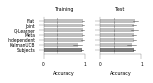

In [18]:

with sns.plotting_context('paper', font_scale=0.5):



    order = exp_3_goals_acc.groupby(['Condition', 'Model']
                ).mean().loc['Training'].sort_values('Acc', ascending=False)

    g = sns.catplot(data=exp_3_goals_acc,
                y='Model', x='Acc', ci='sd', col='Condition',
                col_order=['Training', 'Test'],
                kind='bar', orient='h', color=[0.75, 0.75, 0.75], height=1.1, 
                aspect=1., order=order.index, errwidth=0.5
                   )
    plt.ylabel('')
    plt.xlim([0, 1])
    for ii in [0, 1]:
        g.axes[0][ii].set_xlabel('Accuracy')
        g.axes[0][ii].axvline(x=1./3, c='k', ls=':', lw=0.5)
    # df0 = sims_exp_3.groupby(['Model']).mean().sort_values('Acc')

    g.axes[0][0].set_ylabel('')

    g.axes[0][0].set_title('Training')
    g.axes[0][1].set_title('Test')


    for ax, _bool in zip(g.axes[0], ['Training', 'Test']):
        mu = exp_3_goals_acc[ (_bool == exp_3_goals_acc['Condition'])
        ].groupby('Iteration').mean().mean()['Acc']
        std = exp_3_goals_acc[ (_bool == exp_3_goals_acc['Condition'])
        ].groupby('Iteration').mean().std()['Acc'] 


        ax.barh([6.0], [mu], facecolor='k', alpha=0.5 )
        ax.plot([mu-std, mu+std], [6., 6.], c='k', lw=0.5)

    plt.ylabel('')
    plt.xlim([0, 1])
    plt.xlabel('Accuracy')
    
    for ax in g.axes[0]:
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)


    g.axes[0][0].set_yticks(range(0, 7))
    g.axes[0][0].set_yticklabels(order.index.to_list() + ['Subjects'])
    plt.savefig('exp_3_goals_acc.png', dpi=300)

In [21]:
hdi_data_exp_3_goals = []
for comparison in set(stats_exp_3_goals.Comparison):
    for model in set(stats_exp_3_goals.Model):
        # can use the function from exp_4_goals without modification
        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, comparison, hdi=hdi_interval)
        hdi_data_exp_3_goals.append({
            'Comparison': comparison,
            'Model': model,
            'Mean': get_mean_exp_4_goals(stats_exp_3_goals, model, comparison),  # don't need to rewrite function
            'Lower Bound': lb,
            'Upper Bound': ub
        })
hdi_data_exp_3_goals = pd.DataFrame(hdi_data_exp_3_goals)

In [31]:
hdi_data_exp_3_goals[['Comparison', 'Model', 'Mean', 'Lower Bound', 'Upper Bound']]

,Comparison,Model,Mean,Lower Bound,Upper Bound
0,T1/4 vs T2/3,Q-Learner,0.010675,-0.022807,0.048246
1,T1/4 vs T2/3,Flat,-0.000162,-0.028947,0.031579
2,T1/4 vs T2/3,Independent,0.136991,0.116667,0.157895
3,T1/4 vs T2/3,Joint,0.131053,0.102632,0.157895
4,T1/4 vs T2/3,Meta,0.129175,0.102632,0.159649
5,T1/4 vs T2/3,KalmanUCB,-0.005373,-0.028070,0.021930
6,T1 vs T4,Q-Learner,-0.010342,-0.052632,0.043860
7,T1 vs T4,Flat,0.000421,-0.040351,0.043860
8,T1 vs T4,Independent,0.264781,0.228070,0.296491
9,T1 vs T4,Joint,0.012088,-0.022807,0.047368


In [23]:
def main_effect_mean_sd(model, comp):
    v0 = stats_exp_3_goals.loc[
                (stats_exp_3_goals.Model == model) & 
                (stats_exp_3_goals.Comparison == comp) ,'Mean'].values
    return np.mean(v0), np.std(v0)

def plot_contrasts_exp_3_goals(model, model_name, hdi=0.95):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(1.0, 2.5))  
        sns.barplot(x='Comparison', y='Mean', 
                data=hdi_data_exp_3_goals[(hdi_data_exp_3_goals.Model == model) & 
                                         ((hdi_data_exp_3_goals.Comparison == 'T1 vs T4') | 
                                         (hdi_data_exp_3_goals.Comparison == 'T2 vs T3')
                                         )
                                         ], color='skyblue', ax=ax,
                    ci='sd',
                    order=['T1 vs T4', 'T2 vs T3', 'T1/4 vs T2/3'])
        
#         sns.barplot(x='Comparison', y='Mean', 
#                 data=hdi_data_exp_3_goals[hdi_data_exp_3_goals.Model == model], color='skyblue', ax=ax, 
#                     order=['T1 vs T4', 'T2 vs T3', 'T1/4 vs T2/3'])
        ax.set_ylabel(r'Difference Score', labelpad=-3)
        ax.set_xlabel('')
        ax.plot([-1, 2], [0, 0], 'k:')
        ax.set_xlim([-0.5, 1.5])
        ax.set_ylim([-.2, .25])
        ax.set_yticks(np.arange(-0.1, 0.351, 0.1))
        sns.despine(offset=5)
        
        plt.xticks([0, 1], [r'1 > 4', u'2 > 3', ], rotation='vertical')
        
        # plot the error bars (don't need to re-write function here)
        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T1 vs T4', hdi)
        ax.plot([0, 0],[lb, ub], 'k')
        def plot_stars(x0):
            ax.annotate("*", xy=(x0-0.29, 0.25), size=22)
        if np.sign(lb) == np.sign(ub):
            plot_stars(0)
        
        lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T2 vs T3', hdi)
        ax.plot([1, 1],[lb, ub], 'k')
        if np.sign(lb) == np.sign(ub):
            plot_stars(1)

#         lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T1/4 vs T2/3', hdi)
#         ax.plot([2, 2],[lb, ub], 'k')
#         if np.sign(lb) == np.sign(ub):
#             plot_stars(2)
        
        ax.set_title(model_name)
        return fig, ax
    
def plot_contrasts_exp_3_goals_to_save(model, model_name, height=0.75, hdi=0.95):
    with sns.plotting_context('paper', font_scale=0.5):
        with sns.axes_style('ticks'):
            fig, ax  = plt.subplots(figsize=(height/2.5, height))
            
            sns.barplot(x='Comparison', y='Mean', 
                    data=hdi_data_exp_3_goals[
                        (hdi_data_exp_3_goals.Model == model) & 
                        ((hdi_data_exp_3_goals.Comparison =='T1 vs T4' ) |
                        (hdi_data_exp_3_goals.Comparison == 'T2 vs T3'))], color='skyblue', ax=ax, ci="sd",
                        order=['T1 vs T4',  'T2 vs T3'])
            
            ax.set_ylabel(r'Difference Score', labelpad=0)
            ax.set_xlabel('')
            ax.plot([-1, 2], [0, 0], 'k:', lw=0.5)
            ax.set_xlim([-0.5, 1.5])
            ax.set_yticks(np.arange(-0.2, 0.35, 0.1))
            ax.set_ylim([-0.2, 0.35])
            sns.despine(offset=5)

            plt.xticks([0, 1], [r'1 > 4',  r'2 > 3' ], rotation='vertical')

            def plot_stars(x0):
                ax.annotate("*", xy=(x0-0.175, 0.25), size=8)

            # plot the error bars
            mu, sd = main_effect_mean_sd(model, 'T1 vs T4')
            lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T1 vs T4', hdi)
            ax.plot([0, 0],[mu-sd, mu+sd], 'k', lw=0.5)
            if np.sign(lb) == np.sign(ub):
                plot_stars(0)


            mu, sd = main_effect_mean_sd(model, 'T2 vs T3')
            lb, ub = get_hdi_exp4goals(stats_exp_3_goals, model, 'T2 vs T3', hdi)
            ax.plot([1, 1],[mu-sd, mu+sd], 'k', lw=0.5)

            if np.sign(lb) == np.sign(ub):
                plot_stars(1)

            ax.set_title(model_name)
            ax.spines['left'].set_lw(0.2)
            ax.spines['bottom'].set_lw(0.2)
            ax.tick_params(width=0.2)


            
            return fig, ax

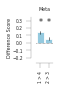

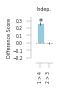

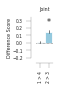

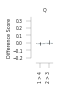

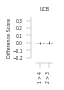

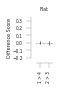

In [24]:
fig, _ = plot_contrasts_exp_3_goals_to_save('Meta', 'Meta')
fig.savefig('exp_3_goals_model_meta.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_3_goals_to_save('Independent', 'Indep.')
fig.savefig('exp_3_goals_model_indep.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_3_goals_to_save('Joint', 'Joint')
fig.savefig('exp_3_goals_model_joint.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_3_goals_to_save('Q-Learner', 'Q')
fig.savefig('exp_3_goals_model_q.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_3_goals_to_save('KalmanUCB', 'UCB')
fig.savefig('exp_3_goals_model_kal.png', dpi=300, bbox_inches='tight')
fig, _ = plot_contrasts_exp_3_goals_to_save('Flat', 'Flat')
fig.savefig('exp_3_goals_model_flat.png', dpi=300, bbox_inches='tight')




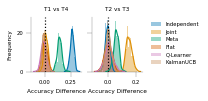

In [30]:
comp1 = stats_exp_3_goals.Comparison =='T1 vs T4'
comp2 = stats_exp_3_goals.Comparison =='T2 vs T3'
model = stats_exp_3_goals.Model
cc = sns.color_palette('colorblind')

with sns.plotting_context('paper', font_scale=0.6):
    _, axes = plt.subplots(1, 2, figsize=(2, 1.), sharey=True)
    def plot_dist(m_name, ii):
            sns.distplot(stats_exp_3_goals.loc[(comp1) & (model == m_name), 'Mean'].values, label=m_name, color=cc[ii],
                        ax=axes[0])

    plot_dist('Independent', 0)
    plot_dist('Joint', 1)
    plot_dist('Meta', 2)
    plot_dist('Flat', 3)
    plot_dist('Q-Learner', 4)
    plot_dist('KalmanUCB', 5)

    def plot_dist(m_name, ii):
        sns.distplot(stats_exp_3_goals.loc[(comp2) & (model == m_name), 'Mean'].values, label=m_name, color=cc[ii],
                    ax=axes[1])

    plot_dist('Independent', 0)
    plot_dist('Joint', 1)
    plot_dist('Meta', 2)
    plot_dist('Flat', 3)
    plot_dist('Q-Learner', 4)
    plot_dist('KalmanUCB', 5)


    axes[0].set_ylabel('Frequency')
    axes[0].set_xlabel('Accuracy Difference')
    axes[0].set_title('T1 vs T4')

    axes[1].set_xlabel('Accuracy Difference')
    axes[1].set_title('T2 vs T3')
    sns.despine()
    
    for ax in axes:
        ax.spines['left'].set_lw(0.2)
        ax.spines['bottom'].set_lw(0.2)
        ax.tick_params(width=0.2)

    lgd = axes[1].legend(loc='upper right', bbox_to_anchor=(2.2, 1.00), framealpha=0)

    for ii in [0, 1]: axes[ii].axvline(x=0, ls=':', color='k') 

    plt.savefig('exp_3_goals_effect_size_all.png', dpi=300,bbox_extra_artists=(lgd,),
                bbox_inches='tight')




# Cross experiment comparions
for these, need to perform regression analysis on the behavioral data




In [88]:
import pymc3 as pm
from theano import tensor as T

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


## Experiment 1

In [89]:
uids = list(set(exp_2_goals_subj.subj))
X0 = exp_2_goals_subj[exp_2_goals_subj['In Goal'] & (exp_2_goals_subj['Times Seen Context'] <= 4) &
              (exp_2_goals_subj['Context'] >= 4)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')

# predictors of interest
x_gA = np.array((X0.Context == 4) | (X0.Context == 5), dtype='int') - \
    np.array(X0.Context == 6, dtype='int')
x_tA = np.array(X0.Task == 'A', dtype='int') - np.array(X0.Task == 'B', dtype='int')
    
# nuissance
x_ti = X0['Times Seen Context'].values
x_ti -= x_ti.mean()
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_exp_2_goals:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_gA = pm.Normal('beta_goalA', mu=0., sd=100)
    b_tA = pm.Normal('beta_taskA', mu=0., sd=100)
    b_ti = pm.Normal('beta_times', mu=0., sd=100)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_gA * x_gA + b_tA * x_tA +
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    
    # inference
    trace_exp_2_goals = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times, beta_taskA, beta_goalA]
The number of effective samples is smaller than 25% for some parameters.


## Experiment 2

In [90]:
X0 = exp_4_goals_subj[~exp_4_goals_subj['Training'] & exp_4_goals_subj['In Goal']].copy()
uids = list(set(exp_4_goals_subj.subj))


X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 8, dtype=int) - \
     (X0.Context.values == 9 )
    
x_2 = np.array((X0.Context.values == 8) | (X0.Context.values == 9), dtype=int) - \
     ((X0.Context.values == 10) | (X0.Context.values == 11))
    
x_3 = np.array(X0.Context.values == 10, dtype=int) - \
     (X0.Context.values == 11)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_exp_4_goals:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs2',   mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT12vs34', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT3vs4',   mu=0., sd=100)
    b_ti = pm.Normal('beta_times',     mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',      mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    glm_trace_exp_4_goals = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times, beta_ctxT3vs4, beta_ctxT12vs34, beta_ctxT1vs2]
The number of effective samples is smaller than 25% for some parameters.


In [91]:
# create meaningful regressors
# really on only want to look at training
X0 = exp_3_goals_subj[~exp_3_goals_subj['Training'] & exp_3_goals_subj['In Goal'] & 
               (exp_3_goals_subj['Times Seen Context'] <= 5)].copy()
uids = list(set(exp_3_goals_subj.subj))


X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 6, dtype='int') - \
     (X0.Context.values == 9)
    
x_2 = np.array(X0.Context.values == 7, dtype='int') - \
     (X0.Context.values == 8) 
    
x_3 = np.array((X0.Context.values == 6) | (X0.Context.values == 9), dtype='int') - \
     ((X0.Context.values == 7) | (X0.Context.values == 8))
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_exp_3_goals:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs4', mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT2vs3', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT1/4vs2/3',  mu=0., sd=100)
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_exp_3_goals = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, a_subj, sigma_sub, mu_subj, beta_reps, beta_times, beta_ctxT1/4vs2/3, beta_ctxT2vs3, beta_ctxT1vs4]


In [92]:
pm.summary(trace_exp_2_goals).loc[['beta_goalA', 'beta_taskA'], 'mean']

beta_goalA    0.007710
beta_taskA   -0.407841
Name: mean, dtype: float64

In [93]:
# comp_a = hdi_data_exp_4_goals.Comparison == 'T1 vs T2'
# comp_b = hdi_data_exp_4_goals.Comparison == 'T3 vs T4'

# hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Meta'), :]

# stats_exp_2_goals.loc[(goalA) & (model == m_name), 'Acc'].values - \
#                      stats_exp_2_goals.loc[(~goalA) & (model == m_name), 'Acc'].values
def main_effect_task_mean_sd(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals.Task == 'B') ,'Acc'].values
    diff = -v0 + v1
    diff.sort()    
    return np.mean(diff), np.std(diff)

def main_effect_goal_mean_sd(model):
    v0 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'A') ,'Acc'].values
    v1 = stats_exp_2_goals.loc[
                (stats_exp_2_goals.Model == model) & 
                (stats_exp_2_goals['Correct Goal'] == 'B') ,'Acc'].values
    diff = v0 - v1
    diff.sort()
    
    return np.mean(diff), np.std(diff)


set(stats_exp_2_goals.Model
)# main_effect_goal_mean_sd('Meta')
# -main_effect_task_mean_sd('Meta')[0]

{'Flat', 'Independent', 'Joint', 'KalmanUCB', 'Meta', 'Q-Learner'}

In [94]:
df = []

meta = [main_effect_goal_mean_sd('Meta')[0], main_effect_task_mean_sd('Meta')[0]]
joint = [main_effect_goal_mean_sd('Meta')[0], main_effect_task_mean_sd('Joint')[0]]
indep = [main_effect_goal_mean_sd('Meta')[0], main_effect_task_mean_sd('Independent')[0]]
subjs = [pm.summary(trace_exp_2_goals).loc[['beta_goalA',], 'mean'].values[0],
        -pm.summary(trace_exp_2_goals).loc[['beta_taskA',], 'mean'].values[0]]


meta /= np.linalg.norm(meta)
joint /= np.linalg.norm(joint)
indep /= np.linalg.norm(indep)
subjs /= np.linalg.norm(subjs)


df.append(pd.DataFrame({
    'Experiment': [1] * 3,
    'angle cos': [np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)],
    'Model': ['Joint', 'Indep.', 'Meta'],
    'NMI': [1.0] * 3
}))

comp_a = hdi_data_exp_4_goals.Comparison == 'T1 vs T2'
comp_b = hdi_data_exp_4_goals.Comparison == 'T3 vs T4'
model = hdi_data_exp_4_goals.Model
meta = hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Meta'), 'Mean'].values
joint = hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Joint'), 'Mean'].values
indep = hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Independent'), 'Mean'].values
subjs = pm.summary(glm_trace_exp_4_goals).loc[['beta_ctxT1vs2', 'beta_ctxT3vs4'], 'mean'].values

meta /= np.linalg.norm(meta)
joint /= np.linalg.norm(joint)
indep /= np.linalg.norm(indep)
subjs /= np.linalg.norm(subjs)

# print np.dot(subjs, flat), np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)
df.append(pd.DataFrame({
    'Experiment': [2] * 3, 
    'angle cos': [np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)],
    'Model': [ 'Joint', 'Indep.', 'Meta'],
    'NMI': [0.126] * 3
}))


comp_a = hdi_data_exp_3_goals.Comparison == 'T1 vs T4'
comp_b = hdi_data_exp_3_goals.Comparison == 'T2 vs T3'
model = hdi_data_exp_3_goals.Model
meta = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Meta'), 'Mean'].values
joint = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Joint'), 'Mean'].values
indep = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Independent'), 'Mean'].values
flat = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Flat'), 'Mean'].values


subjs = pm.summary(trace_exp_3_goals).loc[['beta_ctxT1vs4', 'beta_ctxT2vs3'], 'mean'].values

meta /= np.linalg.norm(meta)
joint /= np.linalg.norm(joint)
indep /= np.linalg.norm(indep)
subjs /= np.linalg.norm(subjs)

df.append(pd.DataFrame({
    'Experiment': [3] * 3,
    'angle cos': [np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)],
    'Model': ['Joint', 'Indep.', 'Meta'],
    'NMI': [0.22] * 3
}))
# the is the nmi for experiments 1, 2 and 3 respectivley


df = pd.concat(df)
df.sort_values('NMI', inplace=True)

# nmi = [1.0, 0.126, 0.22]
# plt.scatter(x=[0.22] * 4, y = [np.dot(subjs, flat), np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)])
# plt.scatter(x=[0.22] * 4, y = [np.dot(subjs, flat), np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)])


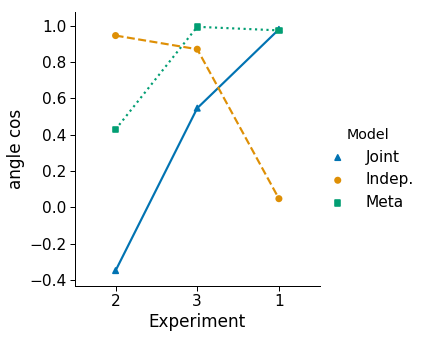

In [95]:
sns.catplot(data=df, x='Experiment', y='angle cos', hue='Model', kind='point', order = [2, 3, 1],
           markers=["^", "o", 's'], linestyles=["-", "--", ":"], palette='colorblind')


In [125]:

df = []

for ii in range(200):
    
    # experiment 1
    
    w_joint, w_indep = [], []
    for w, m in zip([w_joint, w_indep],['Joint', 'Independent']):
        v0 = stats_exp_2_goals.loc[
                    (stats_exp_2_goals.Model == m) & 
                    (stats_exp_2_goals['Correct Goal'] == 'A') &
                    (stats_exp_2_goals.Sample == ii)
            ,'Acc'].mean()
        v1 = stats_exp_2_goals.loc[
                    (stats_exp_2_goals.Model == m) & 
                    (stats_exp_2_goals['Correct Goal'] == 'B') &
                    (stats_exp_2_goals.Sample == ii)
            ,'Acc'].mean()
        w.append(v0 - v1)

        v0 = stats_exp_2_goals.loc[
                    (stats_exp_2_goals.Model == m) & 
                    (stats_exp_2_goals.Task == 'A') &
                    (stats_exp_2_goals.Sample == ii)
            ,'Acc'].mean()
        v1 = stats_exp_2_goals.loc[
                    (stats_exp_2_goals.Model == m) & 
                    (stats_exp_2_goals.Task == 'B').values  &
                    (stats_exp_2_goals.Sample == ii)
            ,'Acc'].mean()
        w.append(-v0 + v1)
        
        
    #draw a sample from the posterior of the subjects distribution
    idx = np.random.randint(len(trace_exp_2_goals))
    w_subj = [trace_exp_2_goals['beta_goalA'][idx], -trace_exp_2_goals['beta_taskA'][idx]]
    
#     w_joint = np.array(w_joint) / np.linalg.norm(w_joint)
#     w_indep = np.array(w_indep) / np.linalg.norm(w_indep)
#     w_subj = np.array(w_subj) / np.linalg.norm(w_subj)

    df.append(pd.DataFrame({
        'Experiment': ["Joint"] * 2,
        'dot product': [np.dot(w_joint, w_subj), np.dot(w_indep, w_subj)],
        'angle cos': [np.dot(w_joint, w_subj) / (np.linalg.norm(w_joint) * np.linalg.norm(w_subj)),
              np.dot(w_indep, w_subj) / (np.linalg.norm(w_indep) * np.linalg.norm(w_subj))],
        'Model': ['Joint', 'Indep.',],
        'NMI': [1.0] * 2,
        'Sample': [ii] * 2,
    }))
    
    # experiment 2
    w_joint, w_indep = [], []
    for w, m in zip([w_joint, w_indep],['Joint', 'Independent']):
        v0 = stats_exp_4_goals.loc[
                    (stats_exp_4_goals.Model == m) & 
                    (stats_exp_4_goals.Comparison == 'T1 vs T2') &
                    (stats_exp_4_goals.Sample == ii)
            ,'Mean'].mean()
        w.append(v0)

        v0 = stats_exp_4_goals.loc[
                    (stats_exp_4_goals.Model == m) & 
                    (stats_exp_4_goals.Comparison == 'T3 vs T4') &
                    (stats_exp_4_goals.Sample == ii)
            ,'Mean'].mean()
        w.append(v0)
        
    #draw a sample from the posterior of the subjects distribution
    idx = np.random.randint(len(glm_trace_exp_4_goals))
    w_subj = [glm_trace_exp_4_goals['beta_ctxT1vs2'][idx], glm_trace_exp_4_goals['beta_ctxT3vs4'][idx]]
    


    df.append(pd.DataFrame({
        'Experiment': ['Indep.'] * 2,
        'dot product': [np.dot(w_joint, w_subj), np.dot(w_indep, w_subj)],
        'angle cos': [np.dot(w_joint, w_subj) / (np.linalg.norm(w_joint) * np.linalg.norm(w_subj)),
                      np.dot(w_indep, w_subj) / (np.linalg.norm(w_indep) * np.linalg.norm(w_subj))],
        'Model': ['Joint', 'Indep.',],
        'NMI': [0.126] * 2,
        'Sample': [ii] * 2,
    }))
    
    # experiment 3
    w_joint, w_indep = [], []
    for w, m in zip([w_joint, w_indep],['Joint', 'Independent']):
        v0 = stats_exp_3_goals.loc[
                    (stats_exp_3_goals.Model == m) & 
                    (stats_exp_3_goals.Comparison == 'T1 vs T4') &
                    (stats_exp_3_goals.Sample == ii)
            ,'Mean'].mean()
        w.append(v0)

        v0 = stats_exp_3_goals.loc[
                    (stats_exp_3_goals.Model == m) & 
                    (stats_exp_3_goals.Comparison == 'T2 vs T3') &
                    (stats_exp_3_goals.Sample == ii)
            ,'Mean'].mean()
        w.append(v0)
        
    #draw a sample from the posterior of the subjects distribution
    idx = np.random.randint(len(trace_exp_3_goals))
    w_subj = [trace_exp_3_goals['beta_ctxT1vs4'][idx], trace_exp_3_goals['beta_ctxT2vs3'][idx]]
    


    df.append(pd.DataFrame({
        'Experiment': ['Ambigous'] * 2,
        'dot product': [np.dot(w_joint, w_subj), np.dot(w_indep, w_subj)],
        'angle cos': [np.dot(w_joint, w_subj) / (np.linalg.norm(w_joint) * np.linalg.norm(w_subj)),
                      np.dot(w_indep, w_subj) / (np.linalg.norm(w_indep) * np.linalg.norm(w_subj))],
        'Model': ['Joint', 'Indep.',],
        'NMI': [0.22] * 2,
        'Sample': [ii] * 2,
    }))
df = pd.concat(df)
angle_cos_df = df.copy()



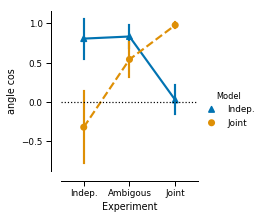

In [126]:
with sns.plotting_context('paper'):
    sns.catplot(data=df, x='Experiment', y='angle cos', hue='Model', kind='point', 
                order = ['Indep.', "Ambigous", "Joint"], hue_order=['Indep.', "Joint"],
               markers=["^", "o", 's'], linestyles=["-", "--", ":"], palette='colorblind', ci='sd', height=3.)
    plt.axhline(y=0, ls=':', c='k')
#     plt.ylabel('contrast similarity')
    sns.despine(offset=10)
    plt.savefig('ModelComp.png', dpi=300, bbox_inches='tight')

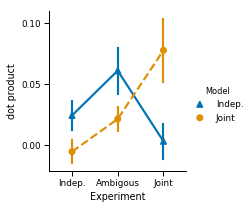

In [98]:
# sns.catplot(data=pd.concat(df), y='angle cos', hue='Model', x='Experiment')
with sns.plotting_context('paper'):
    sns.catplot(data=df, x='Experiment', y='dot product', hue='Model', kind='point', 
                order = ['Indep.', "Ambigous", "Joint"], hue_order=['Indep.', "Joint"],
               markers=["^", "o", 's'], linestyles=["-", "--", ":"], palette='colorblind', ci='sd', height=3.)
#     plt.savefig('ModelComp.png', dpi=300, bbox_inches='tight')



In [99]:
df['scaled dot product'] = df['dot product'] / np.max(np.abs(df['dot product']))

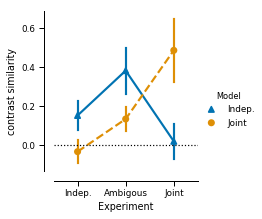

In [100]:
# sns.catplot(data=pd.concat(df), y='angle cos', hue='Model', x='Experiment')
with sns.plotting_context('paper'):
    
    sns.catplot(data=df, x='Experiment', y='scaled dot product', hue='Model', kind='point', 
                order = ['Indep.', "Ambigous", "Joint"], hue_order=['Indep.', "Joint"],
               markers=["^", "o", 's'], linestyles=["-", "--", ":"], palette='colorblind', ci='sd', height=3.)
#     plt.savefig('ModelComp.png', dpi=300, bbox_inches='tight')


    plt.axhline(y=0, ls=':', c='k')
    plt.ylabel('contrast similarity')
    sns.despine(offset=10)

In [101]:
df = []

meta = [main_effect_goal_mean_sd('Meta')[0], main_effect_task_mean_sd('Meta')[0]]
joint = [main_effect_goal_mean_sd('Meta')[0], main_effect_task_mean_sd('Joint')[0]]
indep = [main_effect_goal_mean_sd('Meta')[0], main_effect_task_mean_sd('Independent')[0]]
subjs = [pm.summary(trace_exp_2_goals).loc[['beta_goalA',], 'mean'].values[0],
        -pm.summary(trace_exp_2_goals).loc[['beta_taskA',], 'mean'].values[0]]


meta /= np.linalg.norm(meta)
joint /= np.linalg.norm(joint)
indep /= np.linalg.norm(indep)
subjs /= np.linalg.norm(subjs)


df.append(pd.DataFrame({
    'Experiment': [1] * 3,
    'angle cos': [np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)],
    'Model': ['Joint', 'Indep.', 'Meta'],
    'NMI': [1.0] * 3
}))

comp_a = hdi_data_exp_4_goals.Comparison == 'T1 vs T2'
comp_b = hdi_data_exp_4_goals.Comparison == 'T3 vs T4'
model = hdi_data_exp_4_goals.Model
meta = hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Meta'), 'Mean'].values
joint = hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Joint'), 'Mean'].values
indep = hdi_data_exp_4_goals.loc[(comp_a | comp_b) &( model == 'Independent'), 'Mean'].values
subjs = pm.summary(glm_trace_exp_4_goals).loc[['beta_ctxT1vs2', 'beta_ctxT3vs4'], 'mean'].values

meta /= np.linalg.norm(meta)
joint /= np.linalg.norm(joint)
indep /= np.linalg.norm(indep)
subjs /= np.linalg.norm(subjs)

# print np.dot(subjs, flat), np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)
df.append(pd.DataFrame({
    'Experiment': [2] * 3, 
    'angle cos': [np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)],
    'Model': [ 'Joint', 'Indep.', 'Meta'],
    'NMI': [0.126] * 3
}))


comp_a = hdi_data_exp_3_goals.Comparison == 'T1 vs T4'
comp_b = hdi_data_exp_3_goals.Comparison == 'T2 vs T3'
model = hdi_data_exp_3_goals.Model
meta = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Meta'), 'Mean'].values
joint = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Joint'), 'Mean'].values
indep = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Independent'), 'Mean'].values
flat = hdi_data_exp_3_goals.loc[(comp_a | comp_b) &( model == 'Flat'), 'Mean'].values


subjs = pm.summary(trace_exp_3_goals).loc[['beta_ctxT1vs4', 'beta_ctxT2vs3'], 'mean'].values

meta /= np.linalg.norm(meta)
joint /= np.linalg.norm(joint)
indep /= np.linalg.norm(indep)
subjs /= np.linalg.norm(subjs)

df.append(pd.DataFrame({
    'Experiment': [3] * 3,
    'angle cos': [np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)],
    'Model': ['Joint', 'Indep.', 'Meta'],
    'NMI': [0.22] * 3
}))
# the is the nmi for experiments 1, 2 and 3 respectivley


df = pd.concat(df)
df.sort_values('NMI', inplace=True)

# nmi = [1.0, 0.126, 0.22]
# plt.scatter(x=[0.22] * 4, y = [np.dot(subjs, flat), np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)])
# plt.scatter(x=[0.22] * 4, y = [np.dot(subjs, flat), np.dot(subjs, joint), np.dot(subjs, indep), np.dot(meta, subjs)])



In [104]:
df

,Experiment,Model,NMI,angle cos
0,2,Joint,0.126,-0.348969
1,2,Indep.,0.126,0.945728
2,2,Meta,0.126,0.429013
0,3,Joint,0.220,0.545825
1,3,Indep.,0.220,0.870555
2,3,Meta,0.220,0.993934
0,1,Joint,1.000,0.979838
1,1,Indep.,1.000,0.047349
2,1,Meta,1.000,0.974263


In [105]:
# sns.relplot(data=df, x='model vs meta', y='model vs subj', hue='Model')

# Meta-Agent Comparison

In [106]:
meta_agent_prob = []
for ii in tnrange(200):
    sample_exp_4_goals = draw_batch(sims_exp_4, batch_size=114)
    sample_exp_2_goals = draw_exp_2_sample()
    sample_exp_3_goals = draw_batch(sims_exp_3, batch_size=115)


    meta_2goals = sample_exp_2_goals[(sample_exp_2_goals['Model'] == 'Meta') & sample_exp_2_goals['In Goal']]
    meta_3goals = sample_exp_3_goals[(sample_exp_3_goals['Model'] == 'Meta') & sample_exp_3_goals['In Goal']]
    meta_4goals = sample_exp_4_goals[(sample_exp_4_goals['Model'] == 'Meta') & sample_exp_4_goals['In Goal']]
    
    meta_agent_prob.append({
    'Sample': ii,
    'Exp 1': meta_2goals.loc[meta_2goals['Trial Number'] == 18, 'Joint Probability'].mean(),
    'Exp 2': meta_4goals.loc[meta_4goals['Trial Number'] == 160, 'Joint Probability'].mean(),
    'Exp 3': meta_3goals.loc[meta_3goals['Trial Number'] == 120, 'Joint Probability'].mean(),
    })

In [107]:
meta_agent_prob = pd.DataFrame(meta_agent_prob)

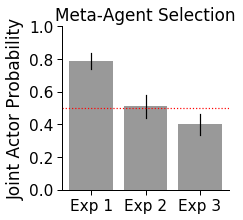

In [108]:
y = meta_agent_prob.mean().loc[['Exp 1', 'Exp 2', 'Exp 3']]
fig, ax = plt.subplots(figsize=(3, 3))
plt.bar(range(3), y, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
sns.despine()

lb, ub = get_hdi(meta_agent_prob['Exp 1'])
plt.plot([0, 0], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 2'])
plt.plot([1, 1], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 3'])
plt.plot([2, 2], [lb, ub], 'k')

ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
ax.set_ylabel('Joint Actor Probability')
sns.despine()
plt.title('Meta-Agent Selection')
plt.savefig('Meta_agents_prob_training_end.png', dpi=300, bbox_inches='tight')

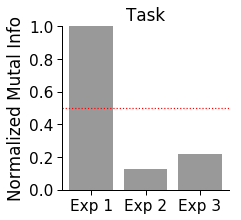

In [109]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.sca(ax)
nmi = [1.0, 0.126, 0.22]
plt.bar(range(3), nmi, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
ax.set_ylabel('Normalized Mutal Info')
ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
plt.title('Task')
sns.despine()
plt.savefig('Training_NMI.png', dpi=300, bbox_inches='tight')


Text(0.5,1,'Task')

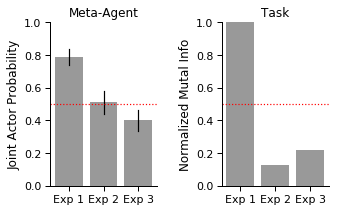

In [112]:
# repeat, but with NMI included
sns.set_context('paper', font_scale=1.25)
y = meta_agent_prob.mean().loc[['Exp 1', 'Exp 2', 'Exp 3']]
fig, axes = plt.subplots(1, 2, figsize=(5, 3), gridspec_kw=dict(wspace=0.6))
ax = axes[0]
plt.sca(ax)
plt.bar(range(3), y, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
sns.despine()

lb, ub = get_hdi(meta_agent_prob['Exp 1'])
plt.plot([0, 0], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 2'])
plt.plot([1, 1], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 3'])
plt.plot([2, 2], [lb, ub], 'k')

ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
ax.set_ylabel('Joint Actor Probability')
sns.despine()
plt.title('Meta-Agent')

ax = axes[1]
plt.sca(ax)
nmi = [1.0, 0.126, 0.22]
plt.bar(range(3), nmi, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
ax.set_ylabel('Normalized Mutal Info')
ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
plt.title('Task')


# plt.savefig('Meta_agents_prob_training_end_NMI.png', dpi=300, bbox_inches='tight')

one figure with the model comparison's and the meta-agent probability

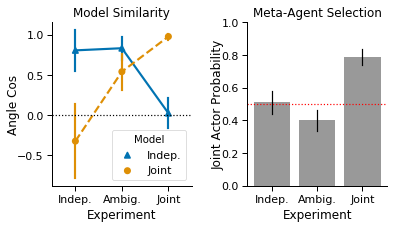

In [156]:
# repeat, but w/o NMI + including the model comparisons
sns.set_context('paper', font_scale=1.25)

# order the experiments by inclreaseing NMI
y = meta_agent_prob.mean().loc[['Exp 2',   'Exp 3', 'Exp 1',]]
fig, axes = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw=dict(wspace=0.4))
ax = axes[1]
plt.sca(ax)
plt.bar(range(3), y, color='k', alpha=0.4)
ax.set_xticks(range(3))
ax.set_xticklabels(['Indep.', "Ambig.", "Joint"])
sns.despine()


lb, ub = get_hdi(meta_agent_prob['Exp 2'])
plt.plot([0, 0], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 3'])
plt.plot([1, 1], [lb, ub], 'k')

lb, ub = get_hdi(meta_agent_prob['Exp 1'])
plt.plot([2, 2], [lb, ub], 'k')




ax.axhline(y=0.5, ls=':', color='r')
ax.set_ylim([0, 1])
ax.set_ylabel('Joint Actor Probability', labelpad=-3)
ax.set_xlabel('Experiment')
sns.despine()
plt.title('Meta-Agent Selection')

ax = axes[0]
sns.pointplot(data=angle_cos_df, x='Experiment', y='angle cos', hue='Model', ax=ax, 
            order = ['Indep.', "Ambigous", "Joint"], hue_order=['Indep.', "Joint"],
           markers=["^", "o", 's'], linestyles=["-", "--", ":"], palette='colorblind', ci='sd', height=3.)
ax.set_ylabel('Angle Cos', labelpad=-3)
ax.axhline(y=0, ls=':', c='k')
ax.set_xticklabels(['Indep.', "Ambig.", "Joint"])
ax.set_title('Model Similarity')

sns.despine()

# #     plt.ylabel('contrast similarity')
#     sns.despine(offset=10)

# ax = axes[1]
# plt.sca(ax)
# nmi = [1.0, 0.126, 0.22]
# plt.bar(range(3), nmi, color='k', alpha=0.4)
# ax.set_xticks(range(3))
# ax.set_xticklabels(['Exp 1', 'Exp 2', 'Exp 3'])
# ax.set_ylabel('Normalized Mutal Info')
# ax.axhline(y=0.5, ls=':', color='r')
# ax.set_ylim([0, 1])
# plt.title('Task')


plt.savefig('Meta_agents_prob_training_end_model_similarity.png', dpi=300, bbox_inches='tight')

In [124]:
df

,Experiment,Model,NMI,angle cos
0,2,Joint,0.126,-0.348969
1,2,Indep.,0.126,0.945728
2,2,Meta,0.126,0.429013
0,3,Joint,0.220,0.545825
1,3,Indep.,0.220,0.870555
2,3,Meta,0.220,0.993934
0,1,Joint,1.000,0.979838
1,1,Indep.,1.000,0.047349
2,1,Meta,1.000,0.974263


In [145]:
help(sns.despine)

Help on function despine in module seaborn.utils:

despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
    Remove the top and right spines from plot(s).
    
    fig : matplotlib figure, optional
        Figure to despine all axes of, default uses current figure.
    ax : matplotlib axes, optional
        Specific axes object to despine.
    top, right, left, bottom : boolean, optional
        If True, remove that spine.
    offset : int or dict, optional
        Absolute distance, in points, spines should be moved away
        from the axes (negative values move spines inward). A single value
        applies to all spines; a dict can be used to set offset values per
        side.
    trim : bool, optional
        If True, limit spines to the smallest and largest major tick
        on each non-despined axis.
    
    Returns
    -------
    None



## Training Accuracy
Bootstrap statistics for training accuracy across experiments

In [ ]:
train_acc_2_g = sims_exp_2.loc[sims_exp_2['In Goal'] & (sims_exp_2['Context'] < 3), :].groupby(
    ['Model', 'Iteration']).mean()['Acc']
train_acc_3_g = sims_exp_3.loc[sims_exp_3['In Goal'] & (sims_exp_3['Context'] < 7), :].groupby(
    ['Model', 'Iteration']).mean()['Acc']
train_acc_4_g = sims_exp_4.loc[sims_exp_4['In Goal'] & (sims_exp_4['Context'] < 9), :].groupby(
    ['Model', 'Iteration']).mean()['Acc']



In [ ]:
def draw_bootstrap_sample_acc_2g(model):
    idx = np.random.permutation(range(2000))[:49 + 80]
    return np.mean(train_acc_2_g.loc[model, idx].values)

def draw_bootstrap_sample_acc_3g(model):
    idx = np.random.permutation(range(1000))[:114]
    return np.mean(train_acc_3_g.loc[model, idx].values)

def draw_bootstrap_sample_acc_4g(model):
    idx = np.random.permutation(range(1000))[:115]
    return np.mean(train_acc_4_g.loc[model, idx].values)

In [ ]:
training_acc = []
for ii in range(100):
    for m in [u'Flat', u'Independent', u'Joint', u'Meta']:
        training_acc.append({
            'Model': m,
            'Experiment': 'Exp 1',
            'Accuracy': draw_bootstrap_sample_acc_2g(m),
            'Iteration': ii,
        })
        training_acc.append({
            'Model': m,
            'Experiment': 'Exp 2',
            'Accuracy': draw_bootstrap_sample_acc_4g(m),
            'Iteration': ii,
        })
        training_acc.append({
            'Model': m,
            'Experiment': 'Exp 3',
            'Accuracy': draw_bootstrap_sample_acc_3g(m),
            'Iteration': ii,
        })
training_acc = pd.DataFrame(training_acc) 

In [ ]:
sns.catplot(data=training_acc, y='Accuracy', x='Model', col='Experiment', kind='bar',)

In [ ]:
# Experiment 1
sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Independent')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Joint')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Meta'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Meta')
plt.legend()
plt.xlabel("Training Accuracy over Flat Agent")

d_i = training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_j = training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_m = training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Meta'), 'Accuracy'].values -\
training_acc.loc[(training_acc.Experiment == 'Exp 1') & (training_acc.Model == 'Flat'), 'Accuracy'].values
# print p_i, p_j, p_m
d_i.sort()
d_j.sort()
d_m.sort()

n = len(d_i)
print "Indep Mean={}, 95% HDI = [{}, {}]".format(d_i.mean(), d_i[int(np.floor(n * 0.025))], d_i[int(np.ceil(n * 0.975))]) 
print "Joint Mean={}, 95% HDI = [{}, {}]".format(d_j.mean(),d_j[int(np.floor(n * 0.025))], d_j[int(np.ceil(n * 0.975))]) 
print "Meta  Mean={}, 95% HDI = [{}, {}]".format(d_m.mean(),d_m[int(np.floor(n * 0.025))], d_m[int(np.ceil(n * 0.975))])


In [ ]:
# Experiment 2
sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Independent')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Joint')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Meta'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Meta')
plt.legend()
plt.xlabel("Training Accuracy over Flat Agent")

d_i = training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_j = training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_m = training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Meta'), 'Accuracy'].values -\
training_acc.loc[(training_acc.Experiment == 'Exp 2') & (training_acc.Model == 'Flat'), 'Accuracy'].values
# print p_i, p_j, p_m
d_i.sort()
d_j.sort()
d_m.sort()

n = len(d_i)
print "Indep Mean={}, 95% HDI = [{}, {}]".format(d_i.mean(), d_i[int(np.floor(n * 0.025))], d_i[int(np.ceil(n * 0.975))]) 
print "Joint Mean={}, 95% HDI = [{}, {}]".format(d_j.mean(), d_j[int(np.floor(n * 0.025))], d_j[int(np.ceil(n * 0.975))]) 
print "Meta  Mean={}, 95% HDI = [{}, {}]".format(d_m.mean(), d_m[int(np.floor(n * 0.025))], d_m[int(np.ceil(n * 0.975))])



In [ ]:
# Experiment 2
sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Independent')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Joint')

sns.distplot(training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Meta'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values, label='Meta')
plt.legend()
plt.xlabel("Training Accuracy over Flat Agent")

d_i = training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Independent'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_j = training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Joint'), 'Accuracy'].values - \
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values
d_m = training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Meta'), 'Accuracy'].values -\
training_acc.loc[(training_acc.Experiment == 'Exp 3') & (training_acc.Model == 'Flat'), 'Accuracy'].values
# print p_i, p_j, p_m
d_i.sort()
d_j.sort()
d_m.sort()

n = len(d_i)
print "Indep Mean={}, 95% HDI = [{}, {}]".format(d_i.mean(), d_i[int(np.floor(n * 0.025))], d_i[int(np.ceil(n * 0.975))]) 
print "Joint Mean={}, 95% HDI = [{}, {}]".format(d_j.mean(), d_j[int(np.floor(n * 0.025))], d_j[int(np.ceil(n * 0.975))]) 
print "Meta  Mean={}, 95% HDI = [{}, {}]".format(d_m.mean(), d_m[int(np.floor(n * 0.025))], d_m[int(np.ceil(n * 0.975))])


